In [1]:
import cloudvolume
import pandas as pd
from imageryclient import ImageryClient
import imageryclient as ic
import matplotlib.pyplot as plt
import numpy as np
import scipy
from PIL import Image
import fastremap
import os
from meshparty import trimesh_io, trimesh_vtk, skeleton, utils
import vtk
import time
from tqdm import tqdm

In [2]:
cb2_em = "precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/em"
img_source = cb2_em
seg_source = "precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/seg"

In [3]:
img_cv = cloudvolume.CloudVolume(cb2_em, mip=0, use_https=True)

In [4]:
print(img_cv.bounds)

Bbox([0, 0, 0],[249600, 230400, 1200], dtype=int32)


In [5]:
img_cv.resolution

Vec(4,4,40, dtype=int32)

In [6]:
# enter a segid or a desired filename for image saving purposes

desc = 'purk_dend_mito_'
segid = 9381230019597

# segid = 3897699205322 non-Purkinje mitochondria; perhaps glial?

In [7]:
imagestacks_dir = 'image_stacks/'+str(desc)+str(segid)+'/' 

In [8]:
imagestacks_dir

'image_stacks/purk_dend_mito_9381230019597/'

In [9]:
os.makedirs(imagestacks_dir, exist_ok=True)

# cb2 EM image visualizer 

In [13]:
# set desired image size

image_size = 2048
half_image_size = image_size/2

# enter coordinates from Neuroglancer; make x and y the same, changing only the z-position

bottom_position = [121377, 83388, 395]
top_position = [121377, 83388, 444]

# non purk mito 3897699205322
# bottom_position = [88113, 75523, 100]
# top_position = [88113, 75523, 130]

zslices = top_position[2] - bottom_position[2]
mid_slice =  int(zslices/2)
mid_position = [bottom_position[0], bottom_position[1], bottom_position[2]+mid_slice]

print(f'Slices:',zslices)
print(f'Mid slice:', mid_slice)
print(f'Mid position:', mid_position)

position_x = mid_position[0]
position_y = mid_position[1]
position_z = mid_position[2]

position_x_min = int(position_x - half_image_size)
position_x_max = int(position_x + half_image_size)
position_y_min = int(position_y - half_image_size)
position_y_max = int(position_y + half_image_size)
position_z_max = position_z + 1

print(position_x_min, position_x_max)
print(position_y_min, position_y_max)
print(position_z, position_z_max)

Slices: 49
Mid slice: 24
Mid position: [121377, 83388, 419]
120353 122401
82364 84412
419 420


In [14]:
img = img_cv[position_x_min:position_x_max, position_y_min:position_y_max, position_z]

Downloading: 100%|██████████| 9/9 [00:48<00:00,  5.36s/it]


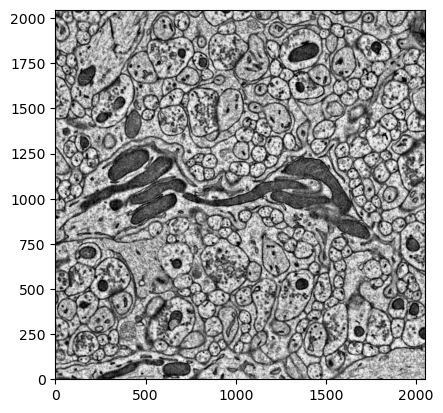

In [15]:
# show image from bottom position
# from: https://stackoverflow.com/questions/31401812/matplotlib-rotate-image-file-by-x-degrees
tr = scipy.ndimage.rotate(img, 90)
plt.imshow(np.squeeze(tr), cmap=plt.cm.gray, origin='lower')

In [17]:
img_client = ic.ImageryClient(image_source=img_source, segmentation_source=seg_source)

## Save single image to disk

In [ ]:
# Save single image to disk; uncomment pil_image.save line

# Convert the numpy array to a PIL image
pil_image = Image.fromarray(image.T)

# Specify the path to the folder and the file name
folder_path = imagestacks_dir
file_name = str(desc) + str(segid) + '_' + str(position_z) + '.png'
file_path = f"{folder_path}/{file_name}"

# Save the image
# pil_image.save(file_path)

print(f"Image saved to {file_path}")


## Generate and save a z-stack of images

In [18]:
# Loop through the zslices with a progress bar
for i in tqdm(range(zslices), desc="Generating Images"):
    # Generate EM image, starting at the bottom z-position
    img_width = image_size
    z_iter = [bottom_position[0], bottom_position[1], bottom_position[2] + i]
    
    # Assuming img_client and ic are already defined and properly set up
    image = img_client.image_cutout(z_iter, bbox_size=(img_width, img_width))
    bounds = ic.bounds_from_center(z_iter, width=img_width, height=img_width, depth=1)
    image = img_client.image_cutout(bounds)
    
    # Convert the numpy array to a PIL image
    pil_image = Image.fromarray(image.T)
    
    # Specify the path to the folder and the file name
    folder_path = imagestacks_dir
    file_name = f"{desc}{segid}_{bottom_position[2] + i}.png"
    file_path = f"{folder_path}/{file_name}"
    
    # Save the image
    pil_image.save(file_path)
    
    print(f"Image saved to {file_path}")


Generating Images:   2%|▏         | 1/49 [01:55<1:32:12, 115.26s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_395.png


Generating Images:   4%|▍         | 2/49 [04:01<1:35:21, 121.74s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_396.png


Generating Images:   6%|▌         | 3/49 [05:09<1:14:31, 97.21s/it] 

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_397.png


Generating Images:   8%|▊         | 4/49 [06:57<1:16:10, 101.56s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_398.png


Generating Images:  10%|█         | 5/49 [08:28<1:11:41, 97.76s/it] 

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_399.png


Generating Images:  12%|█▏        | 6/49 [10:23<1:14:11, 103.53s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_400.png


Generating Images:  14%|█▍        | 7/49 [12:04<1:11:48, 102.59s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_401.png


Generating Images:  16%|█▋        | 8/49 [13:44<1:09:31, 101.75s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_402.png


Generating Images:  18%|█▊        | 9/49 [14:59<1:02:20, 93.51s/it] 

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_403.png


Generating Images:  20%|██        | 10/49 [16:04<55:02, 84.68s/it] 

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_404.png


Generating Images:  22%|██▏       | 11/49 [17:05<49:04, 77.50s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_405.png


Generating Images:  24%|██▍       | 12/49 [18:10<45:25, 73.67s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_406.png


Generating Images:  27%|██▋       | 13/49 [19:11<41:52, 69.79s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_407.png


Generating Images:  29%|██▊       | 14/49 [20:14<39:32, 67.78s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_408.png


Generating Images:  31%|███       | 15/49 [21:18<37:47, 66.68s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_409.png


Generating Images:  33%|███▎      | 16/49 [22:11<34:20, 62.44s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_410.png


Generating Images:  35%|███▍      | 17/49 [23:10<32:46, 61.46s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_411.png


Generating Images:  37%|███▋      | 18/49 [24:14<32:12, 62.34s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_412.png


Generating Images:  39%|███▉      | 19/49 [25:17<31:16, 62.55s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_413.png


Generating Images:  41%|████      | 20/49 [26:52<34:49, 72.04s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_414.png


Generating Images:  43%|████▎     | 21/49 [27:53<32:07, 68.84s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_415.png


Generating Images:  45%|████▍     | 22/49 [28:40<28:01, 62.29s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_416.png


Generating Images:  47%|████▋     | 23/49 [29:39<26:37, 61.46s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_417.png


Generating Images:  49%|████▉     | 24/49 [30:40<25:29, 61.17s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_418.png


Generating Images:  51%|█████     | 25/49 [31:41<24:27, 61.13s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_419.png


Generating Images:  53%|█████▎    | 26/49 [32:50<24:22, 63.58s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_420.png


Generating Images:  55%|█████▌    | 27/49 [33:48<22:40, 61.84s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_421.png


Generating Images:  57%|█████▋    | 28/49 [34:52<21:49, 62.34s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_422.png


Generating Images:  59%|█████▉    | 29/49 [35:41<19:30, 58.52s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_423.png


Generating Images:  61%|██████    | 30/49 [36:33<17:54, 56.57s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_424.png


Generating Images:  63%|██████▎   | 31/49 [37:31<17:02, 56.80s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_425.png


Generating Images:  65%|██████▌   | 32/49 [38:16<15:09, 53.49s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_426.png


Generating Images:  67%|██████▋   | 33/49 [39:32<16:01, 60.08s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_427.png


Generating Images:  69%|██████▉   | 34/49 [40:44<15:54, 63.62s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_428.png


Generating Images:  71%|███████▏  | 35/49 [42:04<15:59, 68.53s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_429.png


Generating Images:  73%|███████▎  | 36/49 [44:31<19:58, 92.23s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_430.png


Generating Images:  76%|███████▌  | 37/49 [45:45<17:21, 86.79s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_431.png


Generating Images:  78%|███████▊  | 38/49 [46:51<14:46, 80.56s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_432.png


Generating Images:  80%|███████▉  | 39/49 [48:00<12:51, 77.12s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_433.png


Generating Images:  82%|████████▏ | 40/49 [49:13<11:21, 75.71s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_434.png


Generating Images:  84%|████████▎ | 41/49 [50:14<09:31, 71.42s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_435.png


Generating Images:  86%|████████▌ | 42/49 [51:40<08:49, 75.66s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_436.png


Generating Images:  88%|████████▊ | 43/49 [52:33<06:52, 68.82s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_437.png


Generating Images:  90%|████████▉ | 44/49 [53:34<05:32, 66.55s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_438.png


Generating Images:  92%|█████████▏| 45/49 [55:57<05:58, 89.51s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_439.png


Generating Images:  94%|█████████▍| 46/49 [56:55<04:00, 80.12s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_440.png


Generating Images:  96%|█████████▌| 47/49 [58:11<02:37, 78.84s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_441.png


Generating Images:  98%|█████████▊| 48/49 [59:54<01:26, 86.12s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_442.png


Generating Images: 100%|██████████| 49/49 [1:01:34<00:00, 75.41s/it]

Image saved to image_stacks/purk_dend_mito_9381230019597//purk_dend_mito_9381230019597_443.png


In [ ]:
# The code in the previous cell can hang; uncomment and run the following to pick up where you left off

# # Define the range for the remaining z values
# start_z = 10
# end_z = 30

# # Loop through the remaining zslices with a progress bar
# for i in tqdm(range(start_z, end_z + 1), desc="Generating Images"):
#     # Generate EM image, starting at the bottom z-position
#     img_width = image_size
#     z_iter = [bottom_position[0], bottom_position[1], bottom_position[2] + i]
    
#     # Assuming img_client and ic are already defined and properly set up
#     image = img_client.image_cutout(z_iter, bbox_size=(img_width, img_width))
#     bounds = ic.bounds_from_center(z_iter, width=img_width, height=img_width, depth=1)
#     image = img_client.image_cutout(bounds)
    
#     # Convert the numpy array to a PIL image
#     pil_image = Image.fromarray(image.T)
    
#     # Specify the path to the folder and the file name
#     folder_path = imagestacks_dir
#     file_name = f"{desc}{segid}_{bottom_position[2] + i}.png"
#     file_path = f"{folder_path}/{file_name}"
    
#     # Save the image
#     pil_image.save(file_path)
    
#     print(f"Image saved to {file_path}")


Link to Purkinje dendrite mitochondria segid 9381230019597 in [neuroglancer](https://neuroglancer.bossdb.io/#!%7B%22dimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%2C%22position%22:%5B121377.5%2C83388.5%2C419.5%5D%2C%22crossSectionScale%22:5%2C%22projectionScale%22:7500%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/em%22%2C%22tab%22:%22source%22%2C%22name%22:%22em%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://s3://bossdb-open-data/mesh/nguyen_thomas2022/cb2/mesh%22%2C%22transform%22:%7B%22matrix%22:%5B%5B0%2C0%2C1000000000%2C0%5D%2C%5B0%2C1000000000%2C0%2C0%5D%2C%5B1000000000%2C0%2C0%2C0%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%7D%7D%2C%22tab%22:%22segments%22%2C%22linkedSegmentationGroup%22:%22seg%22%2C%22name%22:%22mesh%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%5B%7B%22url%22:%22precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/seg%22%2C%22transform%22:%7B%22matrix%22:%5B%5B1%2C0%2C0%2C0%5D%2C%5B0%2C1%2C0%2C0%5D%2C%5B0%2C0%2C1%2C1216%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%7D%7D%2C%22local://equivalences%22%5D%2C%22tab%22:%22source%22%2C%22equivalences%22:%5B%5B%223323082834073%22%2C%227545904169112%22%5D%2C%5B%223323082834073%22%2C%229520490087067%22%5D%2C%5B%223355082752308%22%2C%226696972452171%22%5D%2C%5B%223355082752308%22%2C%226798214432052%22%5D%2C%5B%223552133121049%22%2C%227006705418266%22%5D%2C%5B%223552133121049%22%2C%227491371008028%22%5D%2C%5B%223557183979532%22%2C%225505931675150%22%5D%2C%5B%223557183979532%22%2C%226698173071882%22%5D%2C%5B%223624667055154%22%2C%225779594937398%22%5D%2C%5B%223624667055154%22%2C%227881835807791%22%5D%2C%5B%223653392793780%22%2C%225500042609337%22%5D%2C%5B%223653392793780%22%2C%227112085340340%22%5D%2C%5B%223687567196699%22%2C%226695969752097%22%5D%2C%5B%223687567196699%22%2C%227491371008028%22%5D%2C%5B%223756462572524%22%2C%228346685276652%22%5D%2C%5B%223756462572524%22%2C%229520490087409%22%5D%2C%5B%223791369667583%22%2C%229520490087418%22%5D%2C%5B%223938302689930%22%2C%226546275697800%22%5D%2C%5B%223938302689930%22%2C%2210037768357515%22%5D%2C%5B%223970234449967%22%2C%228108726026284%22%5D%2C%5B%223970234449967%22%2C%228947515392048%22%5D%2C%5B%223974359287590%22%2C%226299743683368%22%5D%2C%5B%223974359287590%22%2C%228641066435363%22%5D%2C%5B%224041012019398%22%2C%224416539197631%22%5D%2C%5B%224041012019398%22%2C%226849866629322%22%5D%2C%5B%224188618096682%22%2C%227006703452209%22%5D%2C%5B%224188618096682%22%2C%227112527052842%22%5D%2C%5B%224303227453687%22%2C%227603315016437%22%5D%2C%5B%224303227453687%22%2C%227714381497596%22%5D%2C%5B%224307691766288%22%2C%225505931675150%22%5D%2C%5B%224307691766288%22%2C%2210378282926097%22%5D%2C%5B%224339784090883%22%2C%227545389712127%22%5D%2C%5B%224339784090883%22%2C%229265041900294%22%5D%2C%5B%224377990268765%22%2C%226696972452171%22%5D%2C%5B%224377990268765%22%2C%226902226616676%22%5D%2C%5B%224416539197631%22%2C%225500042609337%22%5D%2C%5B%224494307492473%22%2C%227006557962360%22%5D%2C%5B%224494307492473%22%2C%227380747550845%22%5D%2C%5B%224533876818538%22%2C%226493843619947%22%5D%2C%5B%224533876818538%22%2C%226798364508264%22%5D%2C%5B%224572983460836%22%2C%227600607068642%22%5D%2C%5B%224572983460836%22%2C%228346685276652%22%5D%2C%5B%224573331456116%22%2C%225912528814188%22%5D%2C%5B%224573331456116%22%2C%227006557962360%22%5D%2C%5B%224609613496572%22%2C%226490228654329%22%5D%2C%5B%224609613496572%22%2C%228640663388413%22%5D%2C%5B%224612664198621%22%2C%227600607068642%22%5D%2C%5B%224612664198621%22%2C%227881831875034%22%5D%2C%5B%224612900782315%22%2C%226443852759789%22%5D%2C%5B%224612900782315%22%2C%227272572518634%22%5D%2C%5B%224654322155556%22%2C%229580488950315%22%5D%2C%5B%224654322155556%22%2C%229645394493474%22%5D%2C%5B%224733321871567%22%2C%226198600007887%22%5D%2C%5B%224733321871567%22%2C%226849866629322%22%5D%2C%5B%224821210235016%22%2C%226546275697800%22%5D%2C%5B%224821210235016%22%2C%229196206162047%22%5D%2C%5B%224857373000530%22%2C%226954117367124%22%5D%2C%5B%224857373000530%22%2C%227827195822412%22%5D%2C%5B%224896984269315%22%2C%226594467595266%22%5D%2C%5B%224896984269315%22%2C%229584942121988%22%5D%2C%5B%224897320468719%22%2C%226544370565357%22%5D%2C%5B%224897320468719%22%2C%226696545157873%22%5D%2C%5B%224945197794887%22%2C%225329709302856%22%5D%2C%5B%224945197794887%22%2C%225778632213059%22%5D%2C%5B%224980529561813%22%2C%225680962601174%22%5D%2C%5B%224980529561813%22%2C%226198600007887%22%5D%2C%5B%224986843301402%22%2C%228946278727708%22%5D%2C%5B%224986843301402%22%2C%228946734858264%22%5D%2C%5B%224986994032751%22%2C%228823104471152%22%5D%2C%5B%224986994032751%22%2C%229387033231469%22%5D%2C%5B%225018911376280%22%2C%227765119467928%22%5D%2C%5B%225018911376280%22%2C%228224196526500%22%5D%2C%5B%225028873503088%22%2C%225242721404779%22%5D%2C%5B%225028873503088%22%2C%229514434560374%22%5D%2C%5B%225061124424733%22%2C%228883216711706%22%5D%2C%5B%225061124424733%22%2C%2212876557844513%22%5D%2C%5B%225070986282463%22%2C%2210581107671520%22%5D%2C%5B%225070986282463%22%2C%2210650450658269%22%5D%2C%5B%225103674328538%22%2C%226243614720476%22%5D%2C%5B%225103674328538%22%2C%2212797488005585%22%5D%2C%5B%225106975375933%22%2C%227059853804092%22%5D%2C%5B%225106975375933%22%2C%227112527709761%22%5D%2C%5B%225108717979097%22%2C%225914279281105%22%5D%2C%5B%225108717979097%22%2C%226396263793116%22%5D%2C%5B%225146258309562%22%2C%227596906907062%22%5D%2C%5B%225146258309562%22%2C%228945380230090%22%5D%2C%5B%225242721403626%22%2C%226853338071268%22%5D%2C%5B%225242721403626%22%2C%227652785520875%22%5D%2C%5B%225242721404098%22%2C%229644420630218%22%5D%2C%5B%225242721404098%22%2C%229907610583234%22%5D%2C%5B%225242721404569%22%2C%229904293806229%22%5D%2C%5B%225242721404569%22%2C%2210107617280155%22%5D%2C%5B%225242721404779%22%2C%2210378282926950%22%5D%2C%5B%225275949465997%22%2C%227820880775049%22%5D%2C%5B%225275949465997%22%2C%2212797672817554%22%5D%2C%5B%225279222333819%22%2C%226901640725885%22%5D%2C%5B%225279222333819%22%2C%227380598784370%22%5D%2C%5B%225285242472091%22%2C%225732519117471%22%5D%2C%5B%225285242472091%22%2C%229008441589918%22%5D%2C%5B%225285707776825%22%2C%229133796884790%22%5D%2C%5B%225285707776825%22%2C%229322507796797%22%5D%2C%5B%225286018417374%22%2C%226058320200924%22%5D%2C%5B%225286018417374%22%2C%229841206886628%22%5D%2C%5B%225286018417784%22%2C%225687280926842%22%5D%2C%5B%225286018417784%22%2C%2210511753544822%22%5D%2C%5B%225286018417992%22%2C%229838080164190%22%5D%2C%5B%225286018417992%22%2C%2210174711072075%22%5D%2C%5B%225286018418216%22%2C%228946430116394%22%5D%2C%5B%225286018418216%22%2C%229196206161957%22%5D%2C%5B%225319589232923%22%2C%225586265703698%22%5D%2C%5B%225319589232923%22%2C%229195139891999%22%5D%2C%5B%225323001693631%22%2C%226644655718836%22%5D%2C%5B%225323001693631%22%2C%226850162853826%22%5D%2C%5B%225323242209341%22%2C%226798637793852%22%5D%2C%5B%225323242209341%22%2C%227769452052543%22%5D%2C%5B%225329709302264%22%2C%2210310296535531%22%5D%2C%5B%225329709302264%22%2C%2210650609254886%22%5D%2C%5B%225329709302270%22%2C%229515385487864%22%5D%2C%5B%225329709302856%22%2C%226107404042314%22%5D%2C%5B%225451734057765%22%2C%226898566431525%22%5D%2C%5B%225451734057765%22%2C%228944073442080%22%5D%2C%5B%225453832519818%22%2C%227937018430861%22%5D%2C%5B%225453832519818%22%2C%2210311680000647%22%5D%2C%5B%225455666218318%22%2C%225866336420684%22%5D%2C%5B%225455666218318%22%2C%226247413843796%22%5D%2C%5B%225457252843843%22%2C%227827195822412%22%5D%2C%5B%225457252843843%22%2C%229451711366467%22%5D%2C%5B%225500066201621%22%2C%227824789995542%22%5D%2C%5B%225500066201621%22%2C%227997225697299%22%5D%2C%5B%225506559508896%22%2C%228284115435938%22%5D%2C%5B%225506559508896%22%2C%228461109168528%22%5D%2C%5B%225541178900674%22%2C%226050881863880%22%5D%2C%5B%225541178900674%22%2C%227431529431739%22%5D%2C%5B%225544931491916%22%2C%227111934607431%22%5D%2C%5B%225544931491916%22%2C%229328514826833%22%5D%2C%5B%225586265703698%22%2C%228639589908751%22%5D%2C%5B%225631596299728%22%2C%228945380230090%22%5D%2C%5B%225631596299728%22%2C%2212797488005585%22%5D%2C%5B%225631703777584%22%2C%227268829758775%22%5D%2C%5B%225631703777584%22%2C%2213274902036775%22%5D%2C%5B%225633867776290%22%2C%227599567012132%22%5D%2C%5B%225633867776290%22%2C%228763650212127%22%5D%2C%5B%225641655420145%22%2C%227652785520875%22%5D%2C%5B%225641655420145%22%2C%2210040323606261%22%5D%2C%5B%225680962601174%22%2C%229584942121692%22%5D%2C%5B%225686493184143%22%2C%227067600815243%22%5D%2C%5B%225686493184143%22%2C%229579998740625%22%5D%2C%5B%225687280272335%22%2C%229323291607506%22%5D%2C%5B%225687280272335%22%2C%229772609700807%22%5D%2C%5B%225687280926842%22%2C%229196206162047%22%5D%2C%5B%225687441490007%22%2C%229451063869528%22%5D%2C%5B%225687441490007%22%2C%229644741754966%22%5D%2C%5B%225732519117471%22%2C%227335080756383%22%5D%2C%5B%225732674438592%22%2C%226059554898369%22%5D%2C%5B%225732674438592%22%2C%226346898146751%22%5D%2C%5B%225733150883872%22%2C%226699411701795%22%5D%2C%5B%225733150883872%22%2C%228282790298143%22%5D%2C%5B%225778316330742%22%2C%229322351822069%22%5D%2C%5B%225778316330742%22%2C%229904293151992%22%5D%2C%5B%225778473615626%22%2C%227444190986507%22%5D%2C%5B%225778473615626%22%2C%229385171354377%22%5D%2C%5B%225778632213059%22%2C%227219867811902%22%5D%2C%5B%225779594937398%22%2C%226107404042294%22%5D%2C%5B%225820854436608%22%2C%227057830053125%22%5D%2C%5B%225820854436608%22%2C%227714381497596%22%5D%2C%5B%225862153257530%22%2C%228821777367097%22%5D%2C%5B%225862153257530%22%2C%229321744302141%22%5D%2C%5B%225862276464763%22%2C%229069538181760%22%5D%2C%5B%225862276464763%22%2C%229132120473719%22%5D%2C%5B%225865806234682%22%2C%226444130631734%22%5D%2C%5B%225865806234682%22%2C%227059853804092%22%5D%2C%5B%225866336420684%22%2C%226247405322560%22%5D%2C%5B%225912528814188%22%2C%227111932641900%22%5D%2C%5B%225914279281105%22%2C%227271556055498%22%5D%2C%5B%225914563051783%22%2C%226849872527625%22%5D%2C%5B%225914563051783%22%2C%229645395149063%22%5D%2C%5B%225916742124720%22%2C%229904293151921%22%5D%2C%5B%225916742124720%22%2C%229971265701034%22%5D%2C%5B%225959828111369%22%2C%226007020584968%22%5D%2C%5B%225959828111369%22%2C%226644933591050%22%5D%2C%5B%225961649356860%22%2C%227057137991737%22%5D%2C%5B%225961649356860%22%2C%227599424143933%22%5D%2C%5B%225961649357339%22%2C%227058972344860%22%5D%2C%5B%225961649357339%22%2C%227272283504669%22%5D%2C%5B%225965078855849%22%2C%228341559706280%22%5D%2C%5B%225965078855849%22%2C%2210103952509610%22%5D%2C%5B%226006797763506%22%2C%226493995664305%22%5D%2C%5B%226006797763506%22%2C%226644655718836%22%5D%2C%5B%226007020584968%22%2C%227768338595846%22%5D%2C%5B%226007036313622%22%2C%226247135314457%22%5D%2C%5B%226007036313622%22%2C%227824789995542%22%5D%2C%5B%226007036314857%22%2C%227272572518634%22%5D%2C%5B%226007036314857%22%2C%229076527596262%22%5D%2C%5B%226050881863880%22%2C%228945087938768%22%5D%2C%5B%226050881865044%22%2C%227377121444175%22%5D%2C%5B%226050881865044%22%2C%2213355734139230%22%5D%2C%5B%226052288266347%22%2C%228582438584429%22%5D%2C%5B%226052288266347%22%2C%229132116541546%22%5D%2C%5B%226053046518069%22%2C%227110508544056%22%5D%2C%5B%226053046518069%22%2C%228886593126707%22%5D%2C%5B%226054371656851%22%2C%227058972344453%22%5D%2C%5B%226054371656851%22%2C%227545904169112%22%5D%2C%5B%226058320200924%22%2C%228762391266011%22%5D%2C%5B%226059554898369%22%2C%229772609700807%22%5D%2C%5B%226102690693208%22%2C%226645218017368%22%5D%2C%5B%226102690693208%22%2C%227436838502484%22%5D%2C%5B%226102690693356%22%2C%226544370565357%22%5D%2C%5B%226102690693356%22%2C%227546786940131%22%5D%2C%5B%226102691349469%22%2C%226696399668695%22%5D%2C%5B%226102691349469%22%2C%227219257017823%22%5D%2C%5B%226103971923210%22%2C%226545694394122%22%5D%2C%5B%226103971923210%22%2C%226849872527625%22%5D%2C%5B%226107404042294%22%2C%229772760432696%22%5D%2C%5B%226107404042314%22%2C%229838380318797%22%5D%2C%5B%226109354393999%22%2C%227937447035275%22%5D%2C%5B%226109354393999%22%2C%228461109168528%22%5D%2C%5B%226146991063134%22%2C%229131973673565%22%5D%2C%5B%226146991063134%22%2C%229972051476579%22%5D%2C%5B%226148167434246%22%2C%228462809825285%22%5D%2C%5B%226148167434246%22%2C%2211150264893447%22%5D%2C%5B%226150514934795%22%2C%226345344942093%22%5D%2C%5B%226150514934795%22%2C%226644933591050%22%5D%2C%5B%226151610040979%22%2C%226798356643995%22%5D%2C%5B%226151610040979%22%2C%227111942471826%22%5D%2C%5B%226151751598971%22%2C%227164879832443%22%5D%2C%5B%226151751598971%22%2C%227490149417335%22%5D%2C%5B%226198967011175%22%2C%226345331836765%22%5D%2C%5B%226198967011175%22%2C%226394679133034%22%5D%2C%5B%226198967664916%22%2C%226544229662984%22%5D%2C%5B%226198967664916%22%2C%226747250360599%22%5D%2C%5B%226200229888623%22%2C%226953971220590%22%5D%2C%5B%226200229888623%22%2C%227164019998837%22%5D%2C%5B%226247135314014%22%2C%226850303754335%22%5D%2C%5B%226247135314014%22%2C%229649864705115%22%5D%2C%5B%226247135314457%22%2C%227006705418266%22%5D%2C%5B%226247405322560%22%2C%227007584256314%22%5D%2C%5B%226247411876289%22%2C%228950974382524%22%5D%2C%5B%226247411876289%22%2C%229714006753747%22%5D%2C%5B%226247413843193%22%2C%226544816210680%22%5D%2C%5B%226247413843193%22%2C%229648972103935%22%5D%2C%5B%226247413843796%22%2C%228054940631384%22%5D%2C%5B%226247548846191%22%2C%226345883648627%22%5D%2C%5B%226247548846191%22%2C%226594747433068%22%5D%2C%5B%226247682539812%22%2C%226296814223648%22%5D%2C%5B%226247682539812%22%2C%226594736292137%22%5D%2C%5B%226248117699572%22%2C%226594594735096%22%5D%2C%5B%226248117699572%22%2C%229978534953955%22%5D%2C%5B%226248247460722%22%2C%226953827042157%22%5D%2C%5B%226248247460722%22%2C%227490149417335%22%5D%2C%5B%226248817623381%22%2C%227112234762583%22%5D%2C%5B%226248817623381%22%2C%227654042501973%22%5D%2C%5B%226248980807798%22%2C%227165468999801%22%5D%2C%5B%226248980807798%22%2C%227823139799158%22%5D%2C%5B%226249419899300%22%2C%227218376214432%22%5D%2C%5B%226249419899300%22%2C%228284422800298%22%5D%2C%5B%226296803085331%22%2C%226956679823376%22%5D%2C%5B%226296803085331%22%2C%228284574842901%22%5D%2C%5B%226296814223648%22%2C%226345326592280%22%5D%2C%5B%226299743683368%22%2C%229133796884790%22%5D%2C%5B%226345326592280%22%2C%226747250360599%22%5D%2C%5B%226345326592395%22%2C%226394673234316%22%5D%2C%5B%226345326592395%22%2C%226594594734976%22%5D%2C%5B%226345331835960%22%2C%226494825349177%22%5D%2C%5B%226345331835960%22%2C%228286924308534%22%5D%2C%5B%226345331836765%22%2C%228054940631384%22%5D%2C%5B%226345344942093%22%2C%226644795310094%22%5D%2C%5B%226345883648627%22%2C%226544512123513%22%5D%2C%5B%226346752001311%22%2C%228641066435363%22%5D%2C%5B%226346752001311%22%2C%229641800500506%22%5D%2C%5B%226346898146751%22%2C%229904293151166%22%5D%2C%5B%226346916495460%22%2C%227993670369377%22%5D%2C%5B%226346916495460%22%2C%229516200756325%22%5D%2C%5B%226391193927908%22%2C%227764843561186%22%5D%2C%5B%226391193927908%22%2C%229258147512549%22%5D%2C%5B%226394670612791%22%2C%226444548752689%22%5D%2C%5B%226394670612791%22%2C%227007584256314%22%5D%2C%5B%226394673234316%22%2C%227713085194640%22%5D%2C%5B%226394673889331%22%2C%228228593336370%22%5D%2C%5B%226394673889331%22%2C%228286924308534%22%5D%2C%5B%226394673889450%22%2C%226798069596836%22%5D%2C%5B%226394673889450%22%2C%226849726382255%22%5D%2C%5B%226394679133034%22%2C%229780228260715%22%5D%2C%5B%226396263793116%22%2C%227823139800032%22%5D%2C%5B%226396541665886%22%2C%226596649943649%22%5D%2C%5B%226396541665886%22%2C%228284266168407%22%5D%2C%5B%226396542321603%22%2C%227270706054574%22%5D%2C%5B%226396542321603%22%2C%227709798564807%22%5D%2C%5B%226443852759789%22%2C%226746965935856%22%5D%2C%5B%226443986453019%22%2C%227271409909788%22%5D%2C%5B%226443986453019%22%2C%2211007219467543%22%5D%2C%5B%226443992351018%22%2C%226798214432052%22%5D%2C%5B%226443992351018%22%2C%227490801500452%22%5D%2C%5B%226444036261140%22%2C%227111940505887%22%5D%2C%5B%226444036261140%22%2C%227112573584655%22%5D%2C%5B%226444130631734%22%2C%226798506723380%22%5D%2C%5B%226444143740666%22%2C%226644981432572%22%5D%2C%5B%226444143740666%22%2C%228585727181562%22%5D%2C%5B%226444267603315%22%2C%226696240415095%22%5D%2C%5B%226444267603315%22%2C%226799513354609%22%5D%2C%5B%226444548752689%22%2C%226594736292137%22%5D%2C%5B%226444553339960%22%2C%227057137991737%22%5D%2C%5B%226444553339960%22%2C%228284423454774%22%5D%2C%5B%226445867991122%22%2C%227654765363277%22%5D%2C%5B%226445867991122%22%2C%227770733282898%22%5D%2C%5B%226446168801679%22%2C%227879857931646%22%5D%2C%5B%226446168801679%22%2C%229451713331601%22%5D%2C%5B%226490228654329%22%2C%227934567384304%22%5D%2C%5B%226493837066284%22%2C%227434426777898%22%5D%2C%5B%226493837066284%22%2C%228521800745004%22%5D%2C%5B%226493843619947%22%2C%226798069596268%22%5D%2C%5B%226493995008914%22%2C%227006559928730%22%5D%2C%5B%226493995008914%22%2C%229138961122182%22%5D%2C%5B%226493995664305%22%2C%227881831220138%22%5D%2C%5B%226494120182199%22%2C%226494261085106%22%5D%2C%5B%226494120182199%22%2C%226902949479867%22%5D%2C%5B%226494128701509%22%2C%227769452052543%22%5D%2C%5B%226494128701509%22%2C%228169891431496%22%5D%2C%5B%226494261085106%22%2C%228766580982185%22%5D%2C%5B%226494261085427%22%2C%226544816210680%22%5D%2C%5B%226494261085427%22%2C%226696545157873%22%5D%2C%5B%226494825349177%22%2C%229200807444538%22%5D%2C%5B%226495579669574%22%2C%228466955634247%22%5D%2C%5B%226495579669574%22%2C%229516036260422%22%5D%2C%5B%226542737409106%22%2C%227271553433677%22%5D%2C%5B%226542737409106%22%2C%229646899855698%22%5D%2C%5B%226544229662984%22%2C%229648972103935%22%5D%2C%5B%226544369909904%22%2C%227382113321612%22%5D%2C%5B%226544369909904%22%2C%227491675750545%22%5D%2C%5B%226544512123513%22%2C%227382113321612%22%5D%2C%5B%226545694394122%22%2C%226698327081738%22%5D%2C%5B%226545695048035%22%2C%226953827042157%22%5D%2C%5B%226545695048035%22%2C%227061401764189%22%5D%2C%5B%226591047270575%22%2C%227431529431739%22%5D%2C%5B%226591047270575%22%2C%227878032752814%22%5D%2C%5B%226592160071796%22%2C%227879716372597%22%5D%2C%5B%226592160071796%22%2C%2210586484244595%22%5D%2C%5B%226592961577361%22%2C%227937018430861%22%5D%2C%5B%226592961577361%22%2C%228169420883347%22%5D%2C%5B%226594029158412%22%2C%228764914402314%22%5D%2C%5B%226594029158412%22%2C%2210042205143055%22%5D%2C%5B%226594467595266%22%2C%226644795310081%22%5D%2C%5B%226594594734976%22%2C%226696240415095%22%5D%2C%5B%226594736947284%22%2C%226645216051793%22%5D%2C%5B%226594736947284%22%2C%227436838502484%22%5D%2C%5B%226594747433068%22%2C%229714362613867%22%5D%2C%5B%226594879160380%22%2C%226798637793852%22%5D%2C%5B%226594879160380%22%2C%227435916410939%22%5D%2C%5B%226595307110586%22%2C%226851032514751%22%5D%2C%5B%226595307110586%22%2C%226955135140024%22%5D%2C%5B%226595459809889%22%2C%227006559273054%22%5D%2C%5B%226595459809889%22%2C%227059263324257%22%5D%2C%5B%226596649943649%22%2C%2210104721244260%22%5D%2C%5B%226602003580891%22%2C%227880302265815%22%5D%2C%5B%226602003580891%22%2C%2210650450658269%22%5D%2C%5B%226641528340718%22%2C%227934567384304%22%5D%2C%5B%226641528340718%22%2C%2213114032784107%22%5D%2C%5B%226644795310094%22%2C%227490144829457%22%5D%2C%5B%226644981432572%22%2C%227545389712127%22%5D%2C%5B%226645076459539%22%2C%227490144829457%22%5D%2C%5B%226645076459539%22%2C%227997225697299%22%5D%2C%5B%226645216051793%22%2C%228228270243920%22%5D%2C%5B%226645218017368%22%2C%228585051504728%22%5D%2C%5B%226645358919873%22%2C%226851027927240%22%5D%2C%5B%226645358919873%22%2C%227491675095231%22%5D%2C%5B%226645360230419%22%2C%226798637793297%22%5D%2C%5B%226645360230419%22%2C%227825569218582%22%5D%2C%5B%226645931705374%22%2C%226747237254171%22%5D%2C%5B%226645931705374%22%2C%229455458713631%22%5D%2C%5B%226646233825441%22%2C%226798069596836%22%5D%2C%5B%226646233825441%22%2C%229584942122141%22%5D%2C%5B%226692126720640%22%2C%227708280095366%22%5D%2C%5B%226692126720640%22%2C%229069538181760%22%5D%2C%5B%226695969752097%22%2C%227272276951074%22%5D%2C%5B%226696399668695%22%2C%229714006753747%22%5D%2C%5B%226696695236097%22%2C%227166355046919%22%5D%2C%5B%226696695236097%22%2C%228053965455361%22%5D%2C%5B%226697583247921%22%2C%227326163927089%22%5D%2C%5B%226697583247921%22%2C%228947515392048%22%5D%2C%5B%226698173071882%22%2C%229775749530633%22%5D%2C%5B%226698327081738%22%2C%227822703329549%22%5D%2C%5B%226698633135479%22%2C%229323133665657%22%5D%2C%5B%226698633135479%22%2C%229514434560374%22%5D%2C%5B%226699411701795%22%2C%226801980784675%22%5D%2C%5B%226744769167361%22%2C%228284561080325%22%5D%2C%5B%226744769167361%22%2C%229385020620801%22%5D%2C%5B%226746965935856%22%2C%227165321545458%22%5D%2C%5B%226747237254171%22%2C%227825569218582%22%5D%2C%5B%226747813316002%22%2C%226799512699813%22%5D%2C%5B%226747813316002%22%2C%227713085194640%22%5D%2C%5B%226797226803702%22%2C%227111074120953%22%5D%2C%5B%226797226803702%22%2C%227164183184882%22%5D%2C%5B%226797923451745%22%2C%228225946993249%22%5D%2C%5B%226797923451745%22%2C%228764914401375%22%5D%2C%5B%226798069596268%22%2C%227111932641900%22%5D%2C%5B%226798069597031%22%2C%226902226616676%22%5D%2C%5B%226798069597031%22%2C%227112677132142%22%5D%2C%5B%226798214430935%22%2C%227655204454635%22%5D%2C%5B%226798214430935%22%2C%227710521426133%22%5D%2C%5B%226798355333310%22%2C%229580651479232%22%5D%2C%5B%226798355333310%22%2C%229974323609779%22%5D%2C%5B%226798356643995%22%2C%227379155681438%22%5D%2C%5B%226798364508264%22%2C%227939947233896%22%5D%2C%5B%226798506723380%22%2C%227544938168369%22%5D%2C%5B%226798637793297%22%2C%227060444938254%22%5D%2C%5B%226799512699813%22%2C%229455262761893%22%5D%2C%5B%226799513354609%22%2C%228229255907182%22%5D%2C%5B%226799522530176%22%2C%228762089144700%22%5D%2C%5B%226799522530176%22%2C%229904295118215%22%5D%2C%5B%226801980784675%22%2C%229196206161957%22%5D%2C%5B%226848741376862%22%2C%227325434513244%22%5D%2C%5B%226848741376862%22%2C%228764914401375%22%5D%2C%5B%226849726382255%22%2C%227112085340340%22%5D%2C%5B%226850158264926%22%2C%227167920046685%22%5D%2C%5B%226850158264926%22%2C%228342587965535%22%5D%2C%5B%226850162853826%22%2C%227111940506053%22%5D%2C%5B%226850303754335%22%2C%227006559273054%22%5D%2C%5B%226851027927240%22%2C%227996417638614%22%5D%2C%5B%226851032514751%22%2C%227491675095231%22%5D%2C%5B%226853338071268%22%2C%229841206886628%22%5D%2C%5B%226898566431525%22%2C%2213274902036775%22%5D%2C%5B%226899848970253%22%2C%228282781777932%22%5D%2C%5B%226899848970253%22%2C%228460506890254%22%5D%2C%5B%226901640725885%22%2C%229520490087295%22%5D%2C%5B%226901646624548%22%2C%227113904620326%22%5D%2C%5B%226901646624548%22%2C%227998054728478%22%5D%2C%5B%226901936293166%22%2C%227006266983211%22%5D%2C%5B%226901936293166%22%2C%227433568911673%22%5D%2C%5B%226902949479867%22%2C%228950974382524%22%5D%2C%5B%226902951444639%22%2C%226955136450728%22%5D%2C%5B%226902951444639%22%2C%227436681216158%22%5D%2C%5B%226903110042178%22%2C%227111934607431%22%5D%2C%5B%226903110042178%22%2C%227112527709761%22%5D%2C%5B%226904043930352%22%2C%227165172123376%22%5D%2C%5B%226904043930352%22%2C%229580488295147%22%5D%2C%5B%226952552366287%22%2C%227164302460367%22%5D%2C%5B%226952552366287%22%2C%229581162660040%22%5D%2C%5B%226952854487364%22%2C%228764914402885%22%5D%2C%5B%226952854487364%22%2C%229711438399043%22%5D%2C%5B%226953971220590%22%2C%227822703329384%22%5D%2C%5B%226954115399685%22%2C%227599570946054%22%5D%2C%5B%226954115399685%22%2C%227655056999941%22%5D%2C%5B%226954116710665%22%2C%227112573584655%22%5D%2C%5B%226954116710665%22%2C%229265041900294%22%5D%2C%5B%226954117367124%22%2C%227654042501973%22%5D%2C%5B%226954986373168%22%2C%226955137105956%22%5D%2C%5B%226954986373168%22%2C%228228593336370%22%5D%2C%5B%226955135140024%22%2C%229013180498095%22%5D%2C%5B%226955136450728%22%2C%227113116877484%22%5D%2C%5B%226955137105956%22%2C%229455458713631%22%5D%2C%5B%226955146282084%22%2C%227059263324257%22%5D%2C%5B%226955146282084%22%2C%227939947233896%22%5D%2C%5B%226956679823376%22%2C%227823139799056%22%5D%2C%5B%227004589917262%22%2C%228341561017944%22%5D%2C%5B%227004589917262%22%2C%228343331799118%22%5D%2C%5B%227006266983211%22%2C%227879417529642%22%5D%2C%5B%227006559273125%22%2C%227379155681438%22%5D%2C%5B%227006559273125%22%2C%228343344906918%22%5D%2C%5B%227006559928730%22%2C%229715081544094%22%5D%2C%5B%227006703452209%22%2C%227544938168369%22%5D%2C%5B%227007432867841%22%2C%227166665031682%22%5D%2C%5B%227014682462254%22%2C%229709936967727%22%5D%2C%5B%227014682462254%22%2C%229970501550122%22%5D%2C%5B%227014861373552%22%2C%228823104471152%22%5D%2C%5B%227014861373552%22%2C%229578886594674%22%5D%2C%5B%227057830053125%22%2C%229775756083973%22%5D%2C%5B%227057970300390%22%2C%227823139800032%22%5D%2C%5B%227057970300390%22%2C%228343344906727%22%5D%2C%5B%227058972344453%22%2C%229520309862532%22%5D%2C%5B%227058972344860%22%2C%228343344906265%22%5D%2C%5B%227059117179817%22%2C%227112528363942%22%5D%2C%5B%227059117179817%22%2C%227881831220138%22%5D%2C%5B%227059117835287%22%2C%229645557678101%22%5D%2C%5B%227059117835287%22%2C%2210108296888344%22%5D%2C%5B%227059263324243%22%2C%227272276951123%22%5D%2C%5B%227059263324243%22%2C%229264686695506%22%5D%2C%5B%227059853149651%22%2C%227111940506053%22%5D%2C%5B%227059853149651%22%2C%227881831875034%22%5D%2C%5B%227060444938254%22%2C%227882299146765%22%5D%2C%5B%227061401764189%22%2C%227823287256920%22%5D%2C%5B%227067600815243%22%2C%2210037768357515%22%5D%2C%5B%227067600815306%22%2C%229515226235084%22%5D%2C%5B%227067600815306%22%2C%229772610355406%22%5D%2C%5B%227108391732384%22%2C%227162017874595%22%5D%2C%5B%227108391732384%22%2C%2212641235107991%22%5D%2C%5B%227110508544056%22%2C%228404590264891%22%5D%2C%5B%227111074120953%22%2C%228523363779582%22%5D%2C%5B%227111074121562%22%2C%227271698269782%22%5D%2C%5B%227111074121562%22%2C%227994432554587%22%5D%2C%5B%227111074121573%22%2C%2210312047658852%22%5D%2C%5B%227111074121573%22%2C%2210448849469544%22%5D%2C%5B%227111789772804%22%2C%227599567011844%22%5D%2C%5B%227111789772804%22%2C%2210448305521665%22%5D%2C%5B%227111940505887%22%2C%227712157860129%22%5D%2C%5B%227111942471826%22%2C%227658783376009%22%5D%2C%5B%227112088618212%22%2C%229076527596262%22%5D%2C%5B%227112088618212%22%2C%229584942121692%22%5D%2C%5B%227112234762583%22%2C%227823287256920%22%5D%2C%5B%227112527052842%22%2C%227824790650920%22%5D%2C%5B%227112528363942%22%2C%229715081544094%22%5D%2C%5B%227112677132142%22%2C%227380598784370%22%5D%2C%5B%227113116877484%22%2C%229013180498095%22%5D%2C%5B%227113128017921%22%2C%228946886246404%22%5D%2C%5B%227113128017921%22%2C%229706983261192%22%5D%2C%5B%227113142436956%22%2C%227996576236130%22%5D%2C%5B%227113142436956%22%2C%228585051504728%22%5D%2C%5B%227113751266306%22%2C%227879710474243%22%5D%2C%5B%227113904620326%22%2C%227879417529642%22%5D%2C%5B%227120424141733%22%2C%228284115435938%22%5D%2C%5B%227120424141733%22%2C%229641949266862%22%5D%2C%5B%227162017874595%22%2C%227878032752814%22%5D%2C%5B%227164016722628%22%2C%227271554089155%22%5D%2C%5B%227164016722628%22%2C%2210865761321412%22%5D%2C%5B%227164019998837%22%2C%227823139799158%22%5D%2C%5B%227164183184882%22%2C%228284590573036%22%5D%2C%5B%227164302459065%22%2C%227271554089155%22%5D%2C%5B%227164302459065%22%2C%2210586667091383%22%5D%2C%5B%227164302459095%22%2C%227489108706010%22%5D%2C%5B%227164302459095%22%2C%2210448672523220%22%5D%2C%5B%227164302459732%22%2C%227271698269782%22%5D%2C%5B%227164302459732%22%2C%229646899855698%22%5D%2C%5B%227164302460367%22%2C%228402871911633%22%5D%2C%5B%227164302461053%22%2C%228110849393784%22%5D%2C%5B%227164302461053%22%2C%2210311680000647%22%5D%2C%5B%227164879832443%22%2C%227879857931646%22%5D%2C%5B%227165172123376%22%2C%227603315016437%22%5D%2C%5B%227165321545458%22%2C%228585727181562%22%5D%2C%5B%227165468344734%22%2C%227218376214432%22%5D%2C%5B%227165468344734%22%2C%229645395804568%22%5D%2C%5B%227165468999801%22%2C%229516035604604%22%5D%2C%5B%227166355046919%22%2C%227882299146765%22%5D%2C%5B%227166665031682%22%2C%228054127984642%22%5D%2C%5B%227167920046685%22%2C%227547438367321%22%5D%2C%5B%227217091052676%22%2C%227936849347715%22%5D%2C%5B%227217091052676%22%2C%229580327075971%22%5D%2C%5B%227217100227332%22%2C%228283958805762%22%5D%2C%5B%227217100227332%22%2C%229068656722703%22%5D%2C%5B%227217652695145%22%2C%229581327810664%22%5D%2C%5B%227217652695145%22%2C%2210448849469544%22%5D%2C%5B%227217652695149%22%2C%2210380386631787%22%5D%2C%5B%227217652695149%22%2C%2210936519885166%22%5D%2C%5B%227217652696066%22%2C%227271409909761%22%5D%2C%5B%227217652696066%22%2C%2210448305521665%22%5D%2C%5B%227217794908193%22%2C%227271410566432%22%5D%2C%5B%227217794908193%22%2C%228763650212127%22%5D%2C%5B%227217795564915%22%2C%228345381110643%22%5D%2C%5B%227217795564915%22%2C%229843068765554%22%5D%2C%5B%227219257017823%22%2C%229978534953955%22%5D%2C%5B%227219867811902%22%2C%228343036231740%22%5D%2C%5B%227227403142903%22%2C%228169420882168%22%5D%2C%5B%227227403142903%22%2C%2210037461648120%22%5D%2C%5B%227268829758775%22%2C%228945087283527%22%5D%2C%5B%227270706054574%22%2C%228284422800298%22%5D%2C%5B%227271290634797%22%2C%227434136453168%22%5D%2C%5B%227271290634797%22%2C%2211078405980205%22%5D%2C%5B%227271409909788%22%2C%227271409909790%22%5D%2C%5B%227271409909790%22%2C%227880906506271%22%5D%2C%5B%227271409910055%22%2C%227599567012132%22%5D%2C%5B%227271409910055%22%2C%228886270690344%22%5D%2C%5B%227271410566432%22%2C%227880906506271%22%5D%2C%5B%227271553433677%22%2C%228169421537864%22%5D%2C%5B%227271556055498%22%2C%227709798564807%22%5D%2C%5B%227272276951074%22%2C%227824790650920%22%5D%2C%5B%227272276951123%22%2C%228524005377111%22%5D%2C%5B%227272283504669%22%2C%228343344906272%22%5D%2C%5B%227272580383869%22%2C%228706511995005%22%5D%2C%5B%227272580383869%22%2C%229520309862532%22%5D%2C%5B%227274421289138%22%2C%229516036260523%22%5D%2C%5B%227274421289138%22%2C%229974323609779%22%5D%2C%5B%227325434513244%22%2C%227994432554587%22%5D%2C%5B%227326163927089%22%2C%228284423454774%22%5D%2C%5B%227335080756383%22%2C%228762543308964%22%5D%2C%5B%227377121444175%22%2C%229385025864012%22%5D%2C%5B%227379154370663%22%2C%227822703329384%22%5D%2C%5B%227379154370663%22%2C%229516200756325%22%5D%2C%5B%227380747550845%22%2C%228706511995005%22%5D%2C%5B%227382112665751%22%2C%227436681216158%22%5D%2C%5B%227382112665751%22%2C%227939142451860%22%5D%2C%5B%227433568911673%22%2C%227879857931069%22%5D%2C%5B%227433863168287%22%2C%227710673472291%22%5D%2C%5B%227433863168287%22%2C%227879422116637%22%5D%2C%5B%227434136453168%22%2C%228886593126707%22%5D%2C%5B%227434136453437%22%2C%228404590264891%22%5D%2C%5B%227434136453437%22%2C%229711438399043%22%5D%2C%5B%227434426777898%22%2C%228886270690344%22%5D%2C%5B%227435010703651%22%2C%227490801500452%22%5D%2C%5B%227435010703651%22%2C%227712157860129%22%5D%2C%5B%227435916410939%22%2C%229200807444538%22%5D%2C%5B%227444190986507%22%2C%2210040320985357%22%5D%2C%5B%227488684687373%22%2C%228343483842577%22%5D%2C%5B%227488684687373%22%2C%229642858905620%22%5D%2C%5B%227489108706010%22%2C%229452555470298%22%5D%2C%5B%227491675750545%22%2C%227939142451860%22%5D%2C%5B%227543481959450%22%2C%228108726026265%22%5D%2C%5B%227543481959450%22%2C%228343344906265%22%5D%2C%5B%227544056054483%22%2C%228402871911633%22%5D%2C%5B%227544056054483%22%2C%2210448672523220%22%5D%2C%5B%227544203510391%22%2C%228110849393784%22%5D%2C%5B%227544203510391%22%2C%2210936337694838%22%5D%2C%5B%227546786940131%22%2C%228228617585890%22%5D%2C%5B%227547438367321%22%2C%227714382151768%22%5D%2C%5B%227547916780028%22%2C%227879857931258%22%5D%2C%5B%227596773212238%22%2C%229194992435276%22%5D%2C%5B%227596773212238%22%2C%2212955581153871%22%5D%2C%5B%227596906907062%22%2C%2213114593771955%22%5D%2C%5B%227599424143933%22%2C%229516036260422%22%5D%2C%5B%227599567011844%22%2C%2210517063270403%22%5D%2C%5B%227599570946054%22%2C%228461411942408%22%5D%2C%5B%227603151831206%22%2C%228284574843047%22%5D%2C%5B%227603151831206%22%2C%229907949404330%22%5D%2C%5B%227652784865336%22%2C%228821777367097%22%5D%2C%5B%227652784865336%22%2C%229258147512373%22%5D%2C%5B%227652922491269%22%2C%227820880775049%22%5D%2C%5B%227652922491269%22%2C%228519541065091%22%5D%2C%5B%227654765363277%22%2C%229516036915275%22%5D%2C%5B%227655056999941%22%2C%227879857930244%22%5D%2C%5B%227655204454635%22%2C%229580488295147%22%5D%2C%5B%227658783376009%22%2C%229580327075971%22%5D%2C%5B%227708280095366%22%2C%228882354258567%22%5D%2C%5B%227710521426133%22%2C%227770571408592%22%5D%2C%5B%227710673472291%22%2C%229134585283370%22%5D%2C%5B%227710674125186%22%2C%227823276114307%22%5D%2C%5B%227710674125186%22%2C%228462653851004%22%5D%2C%5B%227712157860227%22%2C%229138961122182%22%5D%2C%5B%227712157860227%22%2C%229520490087295%22%5D%2C%5B%227714382151768%22%2C%227770733282898%22%5D%2C%5B%227764843561186%22%2C%229008493363420%22%5D%2C%5B%227764886159873%22%2C%2210791508378633%22%5D%2C%5B%227764886159873%22%2C%2212103387054596%22%5D%2C%5B%227764982498112%22%2C%229322507796797%22%5D%2C%5B%227764982498112%22%2C%2210171198996808%22%5D%2C%5B%227765119467928%22%2C%229194989814679%22%5D%2C%5B%227766550119829%22%2C%229515551293841%22%5D%2C%5B%227766550119829%22%2C%229645395804568%22%5D%2C%5B%227766842409974%22%2C%227822992999929%22%5D%2C%5B%227766842409974%22%2C%228343344906727%22%5D%2C%5B%227766847653062%22%2C%229008138814661%22%5D%2C%5B%227766847653062%22%2C%229134266777802%22%5D%2C%5B%227768338595846%22%2C%229584942121988%22%5D%2C%5B%227770571408592%22%2C%227940938137793%22%5D%2C%5B%227822703329549%22%2C%229974323609884%22%5D%2C%5B%227822992999929%22%2C%227879857931258%22%5D%2C%5B%227823139799056%22%2C%229515873075213%22%5D%2C%5B%227823145042890%22%2C%228580145480150%22%5D%2C%5B%227823145042890%22%2C%228884391773127%22%5D%2C%5B%227823276114307%22%2C%228109933855632%22%5D%2C%5B%227824335831049%22%2C%228764914402314%22%5D%2C%5B%227824335831049%22%2C%2210517063270403%22%5D%2C%5B%227879422116637%22%2C%228946120131351%22%5D%2C%5B%227879710474243%22%2C%227879857930244%22%5D%2C%5B%227879716372597%22%2C%228342879600760%22%5D%2C%5B%227879857930882%22%2C%227936849347715%22%5D%2C%5B%227879857930882%22%2C%229515873075841%22%5D%2C%5B%227879857931069%22%2C%229451711366467%22%5D%2C%5B%227880302265815%22%2C%2210375038239190%22%5D%2C%5B%227880314716408%22%2C%228224591053563%22%5D%2C%5B%227880314716408%22%2C%228701058089208%22%5D%2C%5B%227881835807791%22%2C%229196516147248%22%5D%2C%5B%227937437205712%22%2C%228947664814289%22%5D%2C%5B%227937437205712%22%2C%229068658688718%22%5D%2C%5B%227937447035275%22%2C%229196207473035%22%5D%2C%5B%227938056520883%22%2C%229008904274099%22%5D%2C%5B%227938056520883%22%2C%229515385487541%22%5D%2C%5B%227940938137793%22%2C%229580651479232%22%5D%2C%5B%227991818977609%22%2C%228945087283527%22%5D%2C%5B%227991818977609%22%2C%229385025864012%22%5D%2C%5B%227992945542152%22%2C%228282781777932%22%5D%2C%5B%227992945542152%22%2C%228761934479369%22%5D%2C%5B%227993090376510%22%2C%228520115159375%22%5D%2C%5B%227993090376510%22%2C%229257108112184%22%5D%2C%5B%227993378079870%22%2C%229515873075841%22%5D%2C%5B%227993378079870%22%2C%229516035604604%22%5D%2C%5B%227993670369377%22%2C%228342587965535%22%5D%2C%5B%227994705839668%22%2C%229071675965490%22%5D%2C%5B%227994705839668%22%2C%229909310586934%22%5D%2C%5B%227994726155536%22%2C%228108145377554%22%5D%2C%5B%227994726155536%22%2C%229068656722703%22%5D%2C%5B%227996417638614%22%2C%229779156747483%22%5D%2C%5B%227996576236130%22%2C%2210451578389603%22%5D%2C%5B%227998054728478%22%2C%228114133402909%22%5D%2C%5B%228049486070535%22%2C%228699749335294%22%5D%2C%5B%228049486070535%22%2C%228700036382984%22%5D%2C%5B%228049760666205%22%2C%229131973673565%22%5D%2C%5B%228049760666205%22%2C%229449048637526%22%5D%2C%5B%228050045091861%22%2C%228400796385298%22%5D%2C%5B%228050045091861%22%2C%229449048637463%22%5D%2C%5B%228050336071933%22%2C%228051493437696%22%5D%2C%5B%228050336071933%22%2C%228224591053563%22%5D%2C%5B%228050480251692%22%2C%229134585283370%22%5D%2C%5B%228050480251692%22%2C%229198457324847%22%5D%2C%5B%228051197870759%22%2C%228285023764647%22%5D%2C%5B%228051197870759%22%2C%228520123024028%22%5D%2C%5B%228051493437696%22%2C%229193810822400%22%5D%2C%5B%228051792282416%22%2C%228167398441264%22%5D%2C%5B%228051792282416%22%2C%229198457324847%22%5D%2C%5B%228052268729015%22%2C%228522416128180%22%5D%2C%5B%228052268729015%22%2C%228642604564667%22%5D%2C%5B%228053028291002%22%2C%229904293806517%22%5D%2C%5B%228053028291002%22%2C%2210171661026236%22%5D%2C%5B%228053965455361%22%2C%228054127984642%22%5D%2C%5B%228107852431497%22%2C%228882354258567%22%5D%2C%5B%228107852431497%22%2C%2211654989743245%22%5D%2C%5B%228108145377554%22%2C%228460519997718%22%5D%2C%5B%228108289556583%22%2C%228402228346980%22%5D%2C%5B%228108289556583%22%2C%228460362711658%22%5D%2C%5B%228108726026265%22%2C%2210108296888344%22%5D%2C%5B%228108726026284%22%2C%229580488950315%22%5D%2C%5B%228109466584274%22%2C%229708664258772%22%5D%2C%5B%228109466584274%22%2C%229772610355406%22%5D%2C%5B%228109933855632%22%2C%228284108882328%22%5D%2C%5B%228114133402909%22%2C%229974323609884%22%5D%2C%5B%228165650596507%22%2C%229008441589918%22%5D%2C%5B%228165650596507%22%2C%2210512064839836%22%5D%2C%5B%228167100909071%22%2C%228460506890254%22%5D%2C%5B%228167100909071%22%2C%229257844080654%22%5D%2C%5B%228167398441264%22%2C%229257400402224%22%5D%2C%5B%228167406306563%22%2C%228885155922687%22%5D%2C%5B%228167406306563%22%2C%2210310295880452%22%5D%2C%5B%228169420882168%22%2C%229133796884734%22%5D%2C%5B%228169420883347%22%2C%229452383765908%22%5D%2C%5B%228169421537864%22%2C%2210448849470022%22%5D%2C%5B%228169891431496%22%2C%228228270243920%22%5D%2C%5B%228224151961637%22%2C%228760621793827%22%5D%2C%5B%228224151961637%22%2C%229069538182186%22%5D%2C%5B%228224196526500%22%2C%229195139891621%22%5D%2C%5B%228224288931864%22%2C%228402077614110%22%5D%2C%5B%228224288931864%22%2C%228946126685204%22%5D%2C%5B%228225946993249%22%2C%2210312047658852%22%5D%2C%5B%228227797074084%22%2C%228463916729505%22%5D%2C%5B%228227797074084%22%2C%228886271344804%22%5D%2C%5B%228228617585890%22%2C%229779156747483%22%5D%2C%5B%228229255907182%22%2C%229780228260715%22%5D%2C%5B%228282781778126%22%2C%228282790954189%22%5D%2C%5B%228282781778126%22%2C%229068658688718%22%5D%2C%5B%228282790298143%22%2C%229644902318110%22%5D%2C%5B%228282790954189%22%2C%229134266777802%22%5D%2C%5B%228283958805762%22%2C%229193810822400%22%5D%2C%5B%228284108882328%22%2C%228580293591961%22%5D%2C%5B%228284266168407%22%2C%229515385487962%22%5D%2C%5B%228284561080325%22%2C%228462809825285%22%5D%2C%5B%228284561736571%22%2C%228462653851004%22%5D%2C%5B%228284561736571%22%2C%228761935790450%22%5D%2C%5B%228284574842901%22%2C%229645557678101%22%5D%2C%5B%228284574843047%22%2C%228343344906918%22%5D%2C%5B%228284590573036%22%2C%2210586488833251%22%5D%2C%5B%228284715091515%22%2C%228822947185209%22%5D%2C%5B%228284715091515%22%2C%228823550771258%22%5D%2C%5B%228284867789218%22%2C%228762540032413%22%5D%2C%5B%228284867789218%22%2C%229194985882550%22%5D%2C%5B%228285023764647%22%2C%229009684807849%22%5D%2C%5B%228285043426012%22%2C%229513511159502%22%5D%2C%5B%228285043426012%22%2C%2211733508423901%22%5D%2C%5B%228341275934940%22%2C%228580349297366%22%5D%2C%5B%228341275934940%22%2C%229008493363420%22%5D%2C%5B%228341559706280%22%2C%2210580795065511%22%5D%2C%5B%228341559706976%22%2C%229838080164190%22%5D%2C%5B%228341559706976%22%2C%2210378282926950%22%5D%2C%5B%228341561017944%22%2C%228884548403296%22%5D%2C%5B%228341853308266%22%2C%228761935790450%22%5D%2C%5B%228341853308266%22%2C%228946121441628%22%5D%2C%5B%228342735422387%22%2C%229641949266862%22%5D%2C%5B%228342735422387%22%2C%229904293806517%22%5D%2C%5B%228342879600760%22%2C%229384426209402%22%5D%2C%5B%228343036231740%22%2C%229772760432696%22%5D%2C%5B%228343331799118%22%2C%228580008510540%22%5D%2C%5B%228343344906272%22%2C%229645394493474%22%5D%2C%5B%228343483842577%22%2C%229257844080654%22%5D%2C%5B%228345381110643%22%2C%2210936337694838%22%5D%2C%5B%228400796385298%22%2C%229069392035858%22%5D%2C%5B%228402077614110%22%2C%229384573665314%22%5D%2C%5B%228402227692511%22%2C%228580145480150%22%5D%2C%5B%228402227692511%22%2C%229010666538983%22%5D%2C%5B%228402228346980%22%2C%228884548403296%22%5D%2C%5B%228404429702622%22%2C%2210380386633437%22%5D%2C%5B%228404429702622%22%2C%2210586488833251%22%5D%2C%5B%228460215255079%22%2C%229197144637479%22%5D%2C%5B%228460215255079%22%2C%229384573665314%22%5D%2C%5B%228460215255237%22%2C%228641979351743%22%5D%2C%5B%228460215255237%22%2C%229008138814661%22%5D%2C%5B%228460362711658%22%2C%229132116541546%22%5D%2C%5B%228460371230775%22%2C%229257255567928%22%5D%2C%5B%228460371230775%22%2C%229909310586934%22%5D%2C%5B%228460519997718%22%2C%228946120131351%22%5D%2C%5B%228461410632071%22%2C%228701662331274%22%5D%2C%5B%228461410632071%22%2C%229904295118215%22%5D%2C%5B%228461411942408%22%2C%229515873075213%22%5D%2C%5B%228461706199266%22%2C%229643012260072%22%5D%2C%5B%228461706199266%22%2C%2211733508423901%22%5D%2C%5B%228463916729505%22%2C%228463916730527%22%5D%2C%5B%228463916730527%22%2C%229452383765908%22%5D%2C%5B%228466955634247%22%2C%229516036915275%22%5D%2C%5B%228519107871826%22%2C%229259575541842%22%5D%2C%5B%228519107871826%22%2C%229449048637521%22%5D%2C%5B%228519541065091%22%2C%2213355734139230%22%5D%2C%5B%228519684587583%22%2C%229007094825542%22%5D%2C%5B%228519684587583%22%2C%229321744302141%22%5D%2C%5B%228520115159375%22%2C%228946121441628%22%5D%2C%5B%228520123024028%22%2C%229448595128470%22%5D%2C%5B%228521313157622%22%2C%228580293591541%22%5D%2C%5B%228521617899521%22%2C%228699460321281%22%5D%2C%5B%228521800745004%22%2C%2211078405980205%22%5D%2C%5B%228522416128180%22%2C%229068657377447%22%5D%2C%5B%228522572759080%22%2C%229197144637479%22%5D%2C%5B%228522572759080%22%2C%229777606164526%22%5D%2C%5B%228524005377111%22%2C%229649864705115%22%5D%2C%5B%228578706964787%22%2C%229257108112184%22%5D%2C%5B%228578706964787%22%2C%229257400402224%22%5D%2C%5B%228580008510540%22%2C%229194836460617%22%5D%2C%5B%228580145481348%22%2C%228944646881419%22%5D%2C%5B%228580145481348%22%2C%229384426209406%22%5D%2C%5B%228580293591541%22%2C%229010666538983%22%5D%2C%5B%228580293591961%22%2C%228762540032413%22%5D%2C%5B%228580349297366%22%2C%228945087938768%22%5D%2C%5B%228582438584429%22%2C%229708046910061%22%5D%2C%5B%228639445730355%22%2C%229258147512373%22%5D%2C%5B%228639445730355%22%2C%229449048637486%22%5D%2C%5B%228639589908751%22%2C%229194990469389%22%5D%2C%5B%228640663388413%22%2C%228699749335294%22%5D%2C%5B%228641979351743%22%2C%2210865939579070%22%5D%2C%5B%228642604564667%22%2C%229135737407164%22%5D%2C%5B%228642761852345%22%2C%228761491456441%22%5D%2C%5B%228642761852345%22%2C%229194985882550%22%5D%2C%5B%228699460321281%22%2C%229385020620801%22%5D%2C%5B%228700036382984%22%2C%229194990469389%22%5D%2C%5B%228700038350054%22%2C%229258147512549%22%5D%2C%5B%228700038350054%22%2C%2213114032784107%22%5D%2C%5B%228701058089208%22%2C%228761943000306%22%5D%2C%5B%228701662331274%22%2C%229133798195595%22%5D%2C%5B%228760621793827%22%2C%2212876557844513%22%5D%2C%5B%228760910151703%22%2C%229449048637463%22%5D%2C%5B%228760910151703%22%2C%229449199370265%22%5D%2C%5B%228761491456441%22%2C%228822947185599%22%5D%2C%5B%228761934479369%22%2C%2211150264893447%22%5D%2C%5B%228761943000306%22%2C%229009527522033%22%5D%2C%5B%228762089144700%22%2C%229323133665657%22%5D%2C%5B%228762089800807%22%2C%229133796884580%22%5D%2C%5B%228762089800807%22%2C%229386245488748%22%5D%2C%5B%228762391266011%22%2C%229008904929496%22%5D%2C%5B%228762543308964%22%2C%2210584208834726%22%5D%2C%5B%228764914402885%22%2C%2210448849470022%22%5D%2C%5B%228766580982185%22%2C%229455262761893%22%5D%2C%5B%228821487697994%22%2C%229449048637512%22%5D%2C%5B%228821487697994%22%2C%2212719293071436%22%5D%2C%5B%228822362603809%22%2C%228944073442080%22%5D%2C%5B%228822362603809%22%2C%2213436320481568%22%5D%2C%5B%228822947185209%22%2C%229194395402296%22%5D%2C%5B%228822947185599%22%2C%228884391773127%22%5D%2C%5B%228822949151294%22%2C%228882638028861%22%5D%2C%5B%228822949151294%22%2C%2210312209530949%22%5D%2C%5B%228823550771258%22%2C%228882638028861%22%5D%2C%5B%228826088325396%22%2C%2210379669013778%22%5D%2C%5B%228826088325396%22%2C%2211007219467543%22%5D%2C%5B%228883216711706%22%2C%229449199370265%22%5D%2C%5B%228885003223321%22%2C%229641800500506%22%5D%2C%5B%228885003223321%22%2C%2210040320985357%22%5D%2C%5B%228885155922687%22%2C%229133796884734%22%5D%2C%5B%228886270691089%22%2C%2210042205143055%22%5D%2C%5B%228886270691089%22%2C%2210379669013778%22%5D%2C%5B%228886271344804%22%2C%2210517244149938%22%5D%2C%5B%228944646881419%22%2C%229448595128470%22%5D%2C%5B%228945232118925%22%2C%229194989814413%22%5D%2C%5B%228945232118925%22%2C%2211654989743245%22%5D%2C%5B%228946126685204%22%2C%229642858905620%22%5D%2C%5B%228946278727708%22%2C%229644902318110%22%5D%2C%5B%228946430116394%22%2C%229387033231915%22%5D%2C%5B%228946734858264%22%2C%2210378282926097%22%5D%2C%5B%228946886246404%22%2C%2210307050536963%22%5D%2C%5B%228946888213081%22%2C%229451063869528%22%5D%2C%5B%228946888213081%22%2C%229515385487962%22%5D%2C%5B%228947664814289%22%2C%229513511159502%22%5D%2C%5B%229007094825542%22%2C%229449048637512%22%5D%2C%5B%229008904274099%22%2C%229904293151921%22%5D%2C%5B%229008904929496%22%2C%2210378621092055%22%5D%2C%5B%229009369579592%22%2C%229068949667911%22%5D%2C%5B%229009369579592%22%2C%229194836460617%22%5D%2C%5B%229009527522033%22%2C%229130945415407%22%5D%2C%5B%229009684807849%22%2C%229068657377447%22%5D%2C%5B%229068949667853%22%2C%229069392035858%22%5D%2C%5B%229068949667853%22%2C%2210791508378633%22%5D%2C%5B%229068949667911%22%2C%2210312209530949%22%5D%2C%5B%229069538181633%22%2C%2212103387054596%22%5D%2C%5B%229069538181633%22%2C%2212955023441922%22%5D%2C%5B%229069538182186%22%2C%229132120474666%22%5D%2C%5B%229069686948264%22%2C%229195139891621%22%5D%2C%5B%229069686948264%22%2C%2213114593771955%22%5D%2C%5B%229071675965490%22%2C%229777606164526%22%5D%2C%5B%229130945415407%22%2C%229643012260072%22%5D%2C%5B%229132120473719%22%2C%229194992435317%22%5D%2C%5B%229132120474666%22%2C%229194989814314%22%5D%2C%5B%229133796884580%22%2C%2210104721244260%22%5D%2C%5B%229133798195595%22%2C%229196207473035%22%5D%2C%5B%229135737407164%22%2C%2210865939579070%22%5D%2C%5B%229194395402296%22%2C%229257255567928%22%5D%2C%5B%229194989814314%22%2C%229449048637486%22%5D%2C%5B%229194989814413%22%2C%229449047982222%22%5D%2C%5B%229194989814679%22%2C%2212797672817554%22%5D%2C%5B%229194992435276%22%2C%2212719293071436%22%5D%2C%5B%229194992435317%22%2C%229972051476579%22%5D%2C%5B%229195139891999%22%2C%2213436320481568%22%5D%2C%5B%229196516147248%22%2C%229709936967727%22%5D%2C%5B%229256385904789%22%2C%229449047982222%22%5D%2C%5B%229256385904789%22%2C%2212641235107991%22%5D%2C%5B%229259575541842%22%2C%229449048637526%22%5D%2C%5B%229259838996663%22%2C%229515385487541%22%5D%2C%5B%229259838996663%22%2C%2210512222126266%22%5D%2C%5B%229259838996740%22%2C%229451064525064%22%5D%2C%5B%229259838996740%22%2C%2210310295880452%22%5D%2C%5B%229264686695506%22%2C%229328514826833%22%5D%2C%5B%229322351822069%22%2C%2210040323606261%22%5D%2C%5B%229323291607506%22%2C%2210375038239190%22%5D%2C%5B%229384426209402%22%2C%229384426209406%22%5D%2C%5B%229385171354377%22%2C%229451064525064%22%5D%2C%5B%229386245488748%22%2C%229387033231469%22%5D%2C%5B%229387033231915%22%2C%229970501550122%22%5D%2C%5B%229388183389295%22%2C%2210586484901232%22%5D%2C%5B%229388183389295%22%2C%2210936519885166%22%5D%2C%5B%229449048637521%22%2C%2212955581153871%22%5D%2C%5B%229451713331601%22%2C%229515551293841%22%5D%2C%5B%229452555470298%22%2C%2210380386633437%22%5D%2C%5B%229515226235084%22%2C%2210175047270603%22%5D%2C%5B%229515385487864%22%2C%2210310296535531%22%5D%2C%5B%229516036260523%22%2C%229907949404330%22%5D%2C%5B%229520490087067%22%2C%229584942122141%22%5D%2C%5B%229520490087409%22%2C%229520490087411%22%5D%2C%5B%229520490087411%22%2C%229520490087414%22%5D%2C%5B%229520490087414%22%2C%229584942121974%22%5D%2C%5B%229520490087418%22%2C%229584942121976%22%5D%2C%5B%229578886594674%22%2C%2210310295879795%22%5D%2C%5B%229579998740625%22%2C%229904293806229%22%5D%2C%5B%229581162660040%22%2C%2210865761321412%22%5D%2C%5B%229581327810664%22%2C%2210380386631787%22%5D%2C%5B%229584942121974%22%2C%229584942121976%22%5D%2C%5B%229644420630218%22%2C%2210175047270603%22%5D%2C%5B%229644741754966%22%2C%229709936967759%22%5D%2C%5B%229644741755073%22%2C%229907610583234%22%5D%2C%5B%229644741755073%22%2C%229970501550270%22%5D%2C%5B%229645395149063%22%2C%229775756083973%22%5D%2C%5B%229706983261192%22%2C%229709936967689%22%5D%2C%5B%229708046910061%22%2C%229843397100651%22%5D%2C%5B%229708664258772%22%2C%2210378621092055%22%5D%2C%5B%229709936967689%22%2C%229775749530633%22%5D%2C%5B%229709936967759%22%2C%229838380318797%22%5D%2C%5B%229714362613867%22%2C%2210383291842661%22%5D%2C%5B%229772609699841%22%2C%2210650767196162%22%5D%2C%5B%229772760432755%22%2C%2210310295879795%22%5D%2C%5B%229772760432755%22%2C%2210650294026357%22%5D%2C%5B%229775587001161%22%2C%2210174711072075%22%5D%2C%5B%229775587001161%22%2C%2210443635426632%22%5D%2C%5B%229843068765554%22%2C%2210586484901232%22%5D%2C%5B%229843397100651%22%2C%2210586484244595%22%5D%2C%5B%229904293151166%22%2C%2210171661026236%22%5D%2C%5B%229904293151992%22%2C%2210037461648120%22%5D%2C%5B%229970501550270%22%2C%2210720255017150%22%5D%2C%5B%229971265701034%22%2C%2210103952509610%22%5D%2C%5B%2210107617280155%22%2C%2210512064839836%22%5D%2C%5B%2210171198996808%22%2C%2210443635426632%22%5D%2C%5B%2210307050536963%22%2C%2210650767196162%22%5D%2C%5B%2210383291842661%22%2C%2210451578389603%22%5D%2C%5B%2210511753544822%22%2C%2210650294026357%22%5D%2C%5B%2210512222126266%22%2C%2210720255017150%22%5D%2C%5B%2210517244149938%22%2C%2210586667091383%22%5D%2C%5B%2210580795065511%22%2C%2210584208834726%22%5D%2C%5B%2210581107671520%22%2C%2210650609254886%22%5D%2C%5B%2212955023441922%22%2C%2213436320482305%22%5D%5D%2C%22segments%22:%5B%229381230019597%22%2C%229003780014292%22%5D%2C%22name%22:%22seg%22%7D%5D%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22mesh%22%7D%2C%22layout%22:%22xy-3d%22%7D) coordinates only 

Link to non-Purkinje mitochondria segid 3897699205322 in [neuroglancer](
https://neuroglancer.bossdb.io/#!%7B%22dimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%2C%22position%22:%5B87607.125%2C75293.28125%2C115.5%5D%2C%22crossSectionScale%22:10%2C%22projectionOrientation%22:%5B0.5011214017868042%2C0.8452388048171997%2C-0.18185628950595856%2C-0.03710859641432762%5D%2C%22projectionScale%22:10515.167164512257%2C%22layers%22:%5B%7B%22type%22:%22image%22%2C%22source%22:%22precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/em%22%2C%22tab%22:%22source%22%2C%22name%22:%22em%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%7B%22url%22:%22precomputed://s3://bossdb-open-data/mesh/nguyen_thomas2022/cb2/mesh%22%2C%22transform%22:%7B%22matrix%22:%5B%5B0%2C0%2C1000000000%2C0%5D%2C%5B0%2C1000000000%2C0%2C0%5D%2C%5B1000000000%2C0%2C0%2C0%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%7D%7D%2C%22tab%22:%22source%22%2C%22linkedSegmentationGroup%22:%22seg%22%2C%22name%22:%22mesh%22%7D%2C%7B%22type%22:%22segmentation%22%2C%22source%22:%5B%7B%22url%22:%22precomputed://s3://bossdb-open-data/nguyen_thomas2022/cb2/seg%22%2C%22transform%22:%7B%22matrix%22:%5B%5B1%2C0%2C0%2C0%5D%2C%5B0%2C1%2C0%2C0%5D%2C%5B0%2C0%2C1%2C1216%5D%5D%2C%22outputDimensions%22:%7B%22x%22:%5B4e-9%2C%22m%22%5D%2C%22y%22:%5B4e-9%2C%22m%22%5D%2C%22z%22:%5B4e-8%2C%22m%22%5D%7D%7D%7D%2C%22local://equivalences%22%5D%2C%22tab%22:%22segments%22%2C%22equivalences%22:%5B%5B%223323082834073%22%2C%227545904169112%22%5D%2C%5B%223323082834073%22%2C%229520490087067%22%5D%2C%5B%223355082752308%22%2C%226696972452171%22%5D%2C%5B%223355082752308%22%2C%226798214432052%22%5D%2C%5B%223552133121049%22%2C%227006705418266%22%5D%2C%5B%223552133121049%22%2C%227491371008028%22%5D%2C%5B%223557183979532%22%2C%225505931675150%22%5D%2C%5B%223557183979532%22%2C%226698173071882%22%5D%2C%5B%223624667055154%22%2C%225779594937398%22%5D%2C%5B%223624667055154%22%2C%227881835807791%22%5D%2C%5B%223653392793780%22%2C%225500042609337%22%5D%2C%5B%223653392793780%22%2C%227112085340340%22%5D%2C%5B%223687567196699%22%2C%226695969752097%22%5D%2C%5B%223687567196699%22%2C%227491371008028%22%5D%2C%5B%223756462572524%22%2C%228346685276652%22%5D%2C%5B%223756462572524%22%2C%229520490087409%22%5D%2C%5B%223791369667583%22%2C%229520490087418%22%5D%2C%5B%223938302689930%22%2C%226546275697800%22%5D%2C%5B%223938302689930%22%2C%2210037768357515%22%5D%2C%5B%223970234449967%22%2C%228108726026284%22%5D%2C%5B%223970234449967%22%2C%228947515392048%22%5D%2C%5B%223974359287590%22%2C%226299743683368%22%5D%2C%5B%223974359287590%22%2C%228641066435363%22%5D%2C%5B%224041012019398%22%2C%224416539197631%22%5D%2C%5B%224041012019398%22%2C%226849866629322%22%5D%2C%5B%224188618096682%22%2C%227006703452209%22%5D%2C%5B%224188618096682%22%2C%227112527052842%22%5D%2C%5B%224303227453687%22%2C%227603315016437%22%5D%2C%5B%224303227453687%22%2C%227714381497596%22%5D%2C%5B%224307691766288%22%2C%225505931675150%22%5D%2C%5B%224307691766288%22%2C%2210378282926097%22%5D%2C%5B%224339784090883%22%2C%227545389712127%22%5D%2C%5B%224339784090883%22%2C%229265041900294%22%5D%2C%5B%224377990268765%22%2C%226696972452171%22%5D%2C%5B%224377990268765%22%2C%226902226616676%22%5D%2C%5B%224416539197631%22%2C%225500042609337%22%5D%2C%5B%224494307492473%22%2C%227006557962360%22%5D%2C%5B%224494307492473%22%2C%227380747550845%22%5D%2C%5B%224533876818538%22%2C%226493843619947%22%5D%2C%5B%224533876818538%22%2C%226798364508264%22%5D%2C%5B%224572983460836%22%2C%227600607068642%22%5D%2C%5B%224572983460836%22%2C%228346685276652%22%5D%2C%5B%224573331456116%22%2C%225912528814188%22%5D%2C%5B%224573331456116%22%2C%227006557962360%22%5D%2C%5B%224609613496572%22%2C%226490228654329%22%5D%2C%5B%224609613496572%22%2C%228640663388413%22%5D%2C%5B%224612664198621%22%2C%227600607068642%22%5D%2C%5B%224612664198621%22%2C%227881831875034%22%5D%2C%5B%224612900782315%22%2C%226443852759789%22%5D%2C%5B%224612900782315%22%2C%227272572518634%22%5D%2C%5B%224654322155556%22%2C%229580488950315%22%5D%2C%5B%224654322155556%22%2C%229645394493474%22%5D%2C%5B%224733321871567%22%2C%226198600007887%22%5D%2C%5B%224733321871567%22%2C%226849866629322%22%5D%2C%5B%224821210235016%22%2C%226546275697800%22%5D%2C%5B%224821210235016%22%2C%229196206162047%22%5D%2C%5B%224857373000530%22%2C%226954117367124%22%5D%2C%5B%224857373000530%22%2C%227827195822412%22%5D%2C%5B%224896984269315%22%2C%226594467595266%22%5D%2C%5B%224896984269315%22%2C%229584942121988%22%5D%2C%5B%224897320468719%22%2C%226544370565357%22%5D%2C%5B%224897320468719%22%2C%226696545157873%22%5D%2C%5B%224945197794887%22%2C%225329709302856%22%5D%2C%5B%224945197794887%22%2C%225778632213059%22%5D%2C%5B%224980529561813%22%2C%225680962601174%22%5D%2C%5B%224980529561813%22%2C%226198600007887%22%5D%2C%5B%224986843301402%22%2C%228946278727708%22%5D%2C%5B%224986843301402%22%2C%228946734858264%22%5D%2C%5B%224986994032751%22%2C%228823104471152%22%5D%2C%5B%224986994032751%22%2C%229387033231469%22%5D%2C%5B%225018911376280%22%2C%227765119467928%22%5D%2C%5B%225018911376280%22%2C%228224196526500%22%5D%2C%5B%225028873503088%22%2C%225242721404779%22%5D%2C%5B%225028873503088%22%2C%229514434560374%22%5D%2C%5B%225061124424733%22%2C%228883216711706%22%5D%2C%5B%225061124424733%22%2C%2212876557844513%22%5D%2C%5B%225070986282463%22%2C%2210581107671520%22%5D%2C%5B%225070986282463%22%2C%2210650450658269%22%5D%2C%5B%225103674328538%22%2C%226243614720476%22%5D%2C%5B%225103674328538%22%2C%2212797488005585%22%5D%2C%5B%225106975375933%22%2C%227059853804092%22%5D%2C%5B%225106975375933%22%2C%227112527709761%22%5D%2C%5B%225108717979097%22%2C%225914279281105%22%5D%2C%5B%225108717979097%22%2C%226396263793116%22%5D%2C%5B%225146258309562%22%2C%227596906907062%22%5D%2C%5B%225146258309562%22%2C%228945380230090%22%5D%2C%5B%225242721403626%22%2C%226853338071268%22%5D%2C%5B%225242721403626%22%2C%227652785520875%22%5D%2C%5B%225242721404098%22%2C%229644420630218%22%5D%2C%5B%225242721404098%22%2C%229907610583234%22%5D%2C%5B%225242721404569%22%2C%229904293806229%22%5D%2C%5B%225242721404569%22%2C%2210107617280155%22%5D%2C%5B%225242721404779%22%2C%2210378282926950%22%5D%2C%5B%225275949465997%22%2C%227820880775049%22%5D%2C%5B%225275949465997%22%2C%2212797672817554%22%5D%2C%5B%225279222333819%22%2C%226901640725885%22%5D%2C%5B%225279222333819%22%2C%227380598784370%22%5D%2C%5B%225285242472091%22%2C%225732519117471%22%5D%2C%5B%225285242472091%22%2C%229008441589918%22%5D%2C%5B%225285707776825%22%2C%229133796884790%22%5D%2C%5B%225285707776825%22%2C%229322507796797%22%5D%2C%5B%225286018417374%22%2C%226058320200924%22%5D%2C%5B%225286018417374%22%2C%229841206886628%22%5D%2C%5B%225286018417784%22%2C%225687280926842%22%5D%2C%5B%225286018417784%22%2C%2210511753544822%22%5D%2C%5B%225286018417992%22%2C%229838080164190%22%5D%2C%5B%225286018417992%22%2C%2210174711072075%22%5D%2C%5B%225286018418216%22%2C%228946430116394%22%5D%2C%5B%225286018418216%22%2C%229196206161957%22%5D%2C%5B%225319589232923%22%2C%225586265703698%22%5D%2C%5B%225319589232923%22%2C%229195139891999%22%5D%2C%5B%225323001693631%22%2C%226644655718836%22%5D%2C%5B%225323001693631%22%2C%226850162853826%22%5D%2C%5B%225323242209341%22%2C%226798637793852%22%5D%2C%5B%225323242209341%22%2C%227769452052543%22%5D%2C%5B%225329709302264%22%2C%2210310296535531%22%5D%2C%5B%225329709302264%22%2C%2210650609254886%22%5D%2C%5B%225329709302270%22%2C%229515385487864%22%5D%2C%5B%225329709302856%22%2C%226107404042314%22%5D%2C%5B%225451734057765%22%2C%226898566431525%22%5D%2C%5B%225451734057765%22%2C%228944073442080%22%5D%2C%5B%225453832519818%22%2C%227937018430861%22%5D%2C%5B%225453832519818%22%2C%2210311680000647%22%5D%2C%5B%225455666218318%22%2C%225866336420684%22%5D%2C%5B%225455666218318%22%2C%226247413843796%22%5D%2C%5B%225457252843843%22%2C%227827195822412%22%5D%2C%5B%225457252843843%22%2C%229451711366467%22%5D%2C%5B%225500066201621%22%2C%227824789995542%22%5D%2C%5B%225500066201621%22%2C%227997225697299%22%5D%2C%5B%225506559508896%22%2C%228284115435938%22%5D%2C%5B%225506559508896%22%2C%228461109168528%22%5D%2C%5B%225541178900674%22%2C%226050881863880%22%5D%2C%5B%225541178900674%22%2C%227431529431739%22%5D%2C%5B%225544931491916%22%2C%227111934607431%22%5D%2C%5B%225544931491916%22%2C%229328514826833%22%5D%2C%5B%225586265703698%22%2C%228639589908751%22%5D%2C%5B%225631596299728%22%2C%228945380230090%22%5D%2C%5B%225631596299728%22%2C%2212797488005585%22%5D%2C%5B%225631703777584%22%2C%227268829758775%22%5D%2C%5B%225631703777584%22%2C%2213274902036775%22%5D%2C%5B%225633867776290%22%2C%227599567012132%22%5D%2C%5B%225633867776290%22%2C%228763650212127%22%5D%2C%5B%225641655420145%22%2C%227652785520875%22%5D%2C%5B%225641655420145%22%2C%2210040323606261%22%5D%2C%5B%225680962601174%22%2C%229584942121692%22%5D%2C%5B%225686493184143%22%2C%227067600815243%22%5D%2C%5B%225686493184143%22%2C%229579998740625%22%5D%2C%5B%225687280272335%22%2C%229323291607506%22%5D%2C%5B%225687280272335%22%2C%229772609700807%22%5D%2C%5B%225687280926842%22%2C%229196206162047%22%5D%2C%5B%225687441490007%22%2C%229451063869528%22%5D%2C%5B%225687441490007%22%2C%229644741754966%22%5D%2C%5B%225732519117471%22%2C%227335080756383%22%5D%2C%5B%225732674438592%22%2C%226059554898369%22%5D%2C%5B%225732674438592%22%2C%226346898146751%22%5D%2C%5B%225733150883872%22%2C%226699411701795%22%5D%2C%5B%225733150883872%22%2C%228282790298143%22%5D%2C%5B%225778316330742%22%2C%229322351822069%22%5D%2C%5B%225778316330742%22%2C%229904293151992%22%5D%2C%5B%225778473615626%22%2C%227444190986507%22%5D%2C%5B%225778473615626%22%2C%229385171354377%22%5D%2C%5B%225778632213059%22%2C%227219867811902%22%5D%2C%5B%225779594937398%22%2C%226107404042294%22%5D%2C%5B%225820854436608%22%2C%227057830053125%22%5D%2C%5B%225820854436608%22%2C%227714381497596%22%5D%2C%5B%225862153257530%22%2C%228821777367097%22%5D%2C%5B%225862153257530%22%2C%229321744302141%22%5D%2C%5B%225862276464763%22%2C%229069538181760%22%5D%2C%5B%225862276464763%22%2C%229132120473719%22%5D%2C%5B%225865806234682%22%2C%226444130631734%22%5D%2C%5B%225865806234682%22%2C%227059853804092%22%5D%2C%5B%225866336420684%22%2C%226247405322560%22%5D%2C%5B%225912528814188%22%2C%227111932641900%22%5D%2C%5B%225914279281105%22%2C%227271556055498%22%5D%2C%5B%225914563051783%22%2C%226849872527625%22%5D%2C%5B%225914563051783%22%2C%229645395149063%22%5D%2C%5B%225916742124720%22%2C%229904293151921%22%5D%2C%5B%225916742124720%22%2C%229971265701034%22%5D%2C%5B%225959828111369%22%2C%226007020584968%22%5D%2C%5B%225959828111369%22%2C%226644933591050%22%5D%2C%5B%225961649356860%22%2C%227057137991737%22%5D%2C%5B%225961649356860%22%2C%227599424143933%22%5D%2C%5B%225961649357339%22%2C%227058972344860%22%5D%2C%5B%225961649357339%22%2C%227272283504669%22%5D%2C%5B%225965078855849%22%2C%228341559706280%22%5D%2C%5B%225965078855849%22%2C%2210103952509610%22%5D%2C%5B%226006797763506%22%2C%226493995664305%22%5D%2C%5B%226006797763506%22%2C%226644655718836%22%5D%2C%5B%226007020584968%22%2C%227768338595846%22%5D%2C%5B%226007036313622%22%2C%226247135314457%22%5D%2C%5B%226007036313622%22%2C%227824789995542%22%5D%2C%5B%226007036314857%22%2C%227272572518634%22%5D%2C%5B%226007036314857%22%2C%229076527596262%22%5D%2C%5B%226050881863880%22%2C%228945087938768%22%5D%2C%5B%226050881865044%22%2C%227377121444175%22%5D%2C%5B%226050881865044%22%2C%2213355734139230%22%5D%2C%5B%226052288266347%22%2C%228582438584429%22%5D%2C%5B%226052288266347%22%2C%229132116541546%22%5D%2C%5B%226053046518069%22%2C%227110508544056%22%5D%2C%5B%226053046518069%22%2C%228886593126707%22%5D%2C%5B%226054371656851%22%2C%227058972344453%22%5D%2C%5B%226054371656851%22%2C%227545904169112%22%5D%2C%5B%226058320200924%22%2C%228762391266011%22%5D%2C%5B%226059554898369%22%2C%229772609700807%22%5D%2C%5B%226102690693208%22%2C%226645218017368%22%5D%2C%5B%226102690693208%22%2C%227436838502484%22%5D%2C%5B%226102690693356%22%2C%226544370565357%22%5D%2C%5B%226102690693356%22%2C%227546786940131%22%5D%2C%5B%226102691349469%22%2C%226696399668695%22%5D%2C%5B%226102691349469%22%2C%227219257017823%22%5D%2C%5B%226103971923210%22%2C%226545694394122%22%5D%2C%5B%226103971923210%22%2C%226849872527625%22%5D%2C%5B%226107404042294%22%2C%229772760432696%22%5D%2C%5B%226107404042314%22%2C%229838380318797%22%5D%2C%5B%226109354393999%22%2C%227937447035275%22%5D%2C%5B%226109354393999%22%2C%228461109168528%22%5D%2C%5B%226146991063134%22%2C%229131973673565%22%5D%2C%5B%226146991063134%22%2C%229972051476579%22%5D%2C%5B%226148167434246%22%2C%228462809825285%22%5D%2C%5B%226148167434246%22%2C%2211150264893447%22%5D%2C%5B%226150514934795%22%2C%226345344942093%22%5D%2C%5B%226150514934795%22%2C%226644933591050%22%5D%2C%5B%226151610040979%22%2C%226798356643995%22%5D%2C%5B%226151610040979%22%2C%227111942471826%22%5D%2C%5B%226151751598971%22%2C%227164879832443%22%5D%2C%5B%226151751598971%22%2C%227490149417335%22%5D%2C%5B%226198967011175%22%2C%226345331836765%22%5D%2C%5B%226198967011175%22%2C%226394679133034%22%5D%2C%5B%226198967664916%22%2C%226544229662984%22%5D%2C%5B%226198967664916%22%2C%226747250360599%22%5D%2C%5B%226200229888623%22%2C%226953971220590%22%5D%2C%5B%226200229888623%22%2C%227164019998837%22%5D%2C%5B%226247135314014%22%2C%226850303754335%22%5D%2C%5B%226247135314014%22%2C%229649864705115%22%5D%2C%5B%226247135314457%22%2C%227006705418266%22%5D%2C%5B%226247405322560%22%2C%227007584256314%22%5D%2C%5B%226247411876289%22%2C%228950974382524%22%5D%2C%5B%226247411876289%22%2C%229714006753747%22%5D%2C%5B%226247413843193%22%2C%226544816210680%22%5D%2C%5B%226247413843193%22%2C%229648972103935%22%5D%2C%5B%226247413843796%22%2C%228054940631384%22%5D%2C%5B%226247548846191%22%2C%226345883648627%22%5D%2C%5B%226247548846191%22%2C%226594747433068%22%5D%2C%5B%226247682539812%22%2C%226296814223648%22%5D%2C%5B%226247682539812%22%2C%226594736292137%22%5D%2C%5B%226248117699572%22%2C%226594594735096%22%5D%2C%5B%226248117699572%22%2C%229978534953955%22%5D%2C%5B%226248247460722%22%2C%226953827042157%22%5D%2C%5B%226248247460722%22%2C%227490149417335%22%5D%2C%5B%226248817623381%22%2C%227112234762583%22%5D%2C%5B%226248817623381%22%2C%227654042501973%22%5D%2C%5B%226248980807798%22%2C%227165468999801%22%5D%2C%5B%226248980807798%22%2C%227823139799158%22%5D%2C%5B%226249419899300%22%2C%227218376214432%22%5D%2C%5B%226249419899300%22%2C%228284422800298%22%5D%2C%5B%226296803085331%22%2C%226956679823376%22%5D%2C%5B%226296803085331%22%2C%228284574842901%22%5D%2C%5B%226296814223648%22%2C%226345326592280%22%5D%2C%5B%226299743683368%22%2C%229133796884790%22%5D%2C%5B%226345326592280%22%2C%226747250360599%22%5D%2C%5B%226345326592395%22%2C%226394673234316%22%5D%2C%5B%226345326592395%22%2C%226594594734976%22%5D%2C%5B%226345331835960%22%2C%226494825349177%22%5D%2C%5B%226345331835960%22%2C%228286924308534%22%5D%2C%5B%226345331836765%22%2C%228054940631384%22%5D%2C%5B%226345344942093%22%2C%226644795310094%22%5D%2C%5B%226345883648627%22%2C%226544512123513%22%5D%2C%5B%226346752001311%22%2C%228641066435363%22%5D%2C%5B%226346752001311%22%2C%229641800500506%22%5D%2C%5B%226346898146751%22%2C%229904293151166%22%5D%2C%5B%226346916495460%22%2C%227993670369377%22%5D%2C%5B%226346916495460%22%2C%229516200756325%22%5D%2C%5B%226391193927908%22%2C%227764843561186%22%5D%2C%5B%226391193927908%22%2C%229258147512549%22%5D%2C%5B%226394670612791%22%2C%226444548752689%22%5D%2C%5B%226394670612791%22%2C%227007584256314%22%5D%2C%5B%226394673234316%22%2C%227713085194640%22%5D%2C%5B%226394673889331%22%2C%228228593336370%22%5D%2C%5B%226394673889331%22%2C%228286924308534%22%5D%2C%5B%226394673889450%22%2C%226798069596836%22%5D%2C%5B%226394673889450%22%2C%226849726382255%22%5D%2C%5B%226394679133034%22%2C%229780228260715%22%5D%2C%5B%226396263793116%22%2C%227823139800032%22%5D%2C%5B%226396541665886%22%2C%226596649943649%22%5D%2C%5B%226396541665886%22%2C%228284266168407%22%5D%2C%5B%226396542321603%22%2C%227270706054574%22%5D%2C%5B%226396542321603%22%2C%227709798564807%22%5D%2C%5B%226443852759789%22%2C%226746965935856%22%5D%2C%5B%226443986453019%22%2C%227271409909788%22%5D%2C%5B%226443986453019%22%2C%2211007219467543%22%5D%2C%5B%226443992351018%22%2C%226798214432052%22%5D%2C%5B%226443992351018%22%2C%227490801500452%22%5D%2C%5B%226444036261140%22%2C%227111940505887%22%5D%2C%5B%226444036261140%22%2C%227112573584655%22%5D%2C%5B%226444130631734%22%2C%226798506723380%22%5D%2C%5B%226444143740666%22%2C%226644981432572%22%5D%2C%5B%226444143740666%22%2C%228585727181562%22%5D%2C%5B%226444267603315%22%2C%226696240415095%22%5D%2C%5B%226444267603315%22%2C%226799513354609%22%5D%2C%5B%226444548752689%22%2C%226594736292137%22%5D%2C%5B%226444553339960%22%2C%227057137991737%22%5D%2C%5B%226444553339960%22%2C%228284423454774%22%5D%2C%5B%226445867991122%22%2C%227654765363277%22%5D%2C%5B%226445867991122%22%2C%227770733282898%22%5D%2C%5B%226446168801679%22%2C%227879857931646%22%5D%2C%5B%226446168801679%22%2C%229451713331601%22%5D%2C%5B%226490228654329%22%2C%227934567384304%22%5D%2C%5B%226493837066284%22%2C%227434426777898%22%5D%2C%5B%226493837066284%22%2C%228521800745004%22%5D%2C%5B%226493843619947%22%2C%226798069596268%22%5D%2C%5B%226493995008914%22%2C%227006559928730%22%5D%2C%5B%226493995008914%22%2C%229138961122182%22%5D%2C%5B%226493995664305%22%2C%227881831220138%22%5D%2C%5B%226494120182199%22%2C%226494261085106%22%5D%2C%5B%226494120182199%22%2C%226902949479867%22%5D%2C%5B%226494128701509%22%2C%227769452052543%22%5D%2C%5B%226494128701509%22%2C%228169891431496%22%5D%2C%5B%226494261085106%22%2C%228766580982185%22%5D%2C%5B%226494261085427%22%2C%226544816210680%22%5D%2C%5B%226494261085427%22%2C%226696545157873%22%5D%2C%5B%226494825349177%22%2C%229200807444538%22%5D%2C%5B%226495579669574%22%2C%228466955634247%22%5D%2C%5B%226495579669574%22%2C%229516036260422%22%5D%2C%5B%226542737409106%22%2C%227271553433677%22%5D%2C%5B%226542737409106%22%2C%229646899855698%22%5D%2C%5B%226544229662984%22%2C%229648972103935%22%5D%2C%5B%226544369909904%22%2C%227382113321612%22%5D%2C%5B%226544369909904%22%2C%227491675750545%22%5D%2C%5B%226544512123513%22%2C%227382113321612%22%5D%2C%5B%226545694394122%22%2C%226698327081738%22%5D%2C%5B%226545695048035%22%2C%226953827042157%22%5D%2C%5B%226545695048035%22%2C%227061401764189%22%5D%2C%5B%226591047270575%22%2C%227431529431739%22%5D%2C%5B%226591047270575%22%2C%227878032752814%22%5D%2C%5B%226592160071796%22%2C%227879716372597%22%5D%2C%5B%226592160071796%22%2C%2210586484244595%22%5D%2C%5B%226592961577361%22%2C%227937018430861%22%5D%2C%5B%226592961577361%22%2C%228169420883347%22%5D%2C%5B%226594029158412%22%2C%228764914402314%22%5D%2C%5B%226594029158412%22%2C%2210042205143055%22%5D%2C%5B%226594467595266%22%2C%226644795310081%22%5D%2C%5B%226594594734976%22%2C%226696240415095%22%5D%2C%5B%226594736947284%22%2C%226645216051793%22%5D%2C%5B%226594736947284%22%2C%227436838502484%22%5D%2C%5B%226594747433068%22%2C%229714362613867%22%5D%2C%5B%226594879160380%22%2C%226798637793852%22%5D%2C%5B%226594879160380%22%2C%227435916410939%22%5D%2C%5B%226595307110586%22%2C%226851032514751%22%5D%2C%5B%226595307110586%22%2C%226955135140024%22%5D%2C%5B%226595459809889%22%2C%227006559273054%22%5D%2C%5B%226595459809889%22%2C%227059263324257%22%5D%2C%5B%226596649943649%22%2C%2210104721244260%22%5D%2C%5B%226602003580891%22%2C%227880302265815%22%5D%2C%5B%226602003580891%22%2C%2210650450658269%22%5D%2C%5B%226641528340718%22%2C%227934567384304%22%5D%2C%5B%226641528340718%22%2C%2213114032784107%22%5D%2C%5B%226644795310094%22%2C%227490144829457%22%5D%2C%5B%226644981432572%22%2C%227545389712127%22%5D%2C%5B%226645076459539%22%2C%227490144829457%22%5D%2C%5B%226645076459539%22%2C%227997225697299%22%5D%2C%5B%226645216051793%22%2C%228228270243920%22%5D%2C%5B%226645218017368%22%2C%228585051504728%22%5D%2C%5B%226645358919873%22%2C%226851027927240%22%5D%2C%5B%226645358919873%22%2C%227491675095231%22%5D%2C%5B%226645360230419%22%2C%226798637793297%22%5D%2C%5B%226645360230419%22%2C%227825569218582%22%5D%2C%5B%226645931705374%22%2C%226747237254171%22%5D%2C%5B%226645931705374%22%2C%229455458713631%22%5D%2C%5B%226646233825441%22%2C%226798069596836%22%5D%2C%5B%226646233825441%22%2C%229584942122141%22%5D%2C%5B%226692126720640%22%2C%227708280095366%22%5D%2C%5B%226692126720640%22%2C%229069538181760%22%5D%2C%5B%226695969752097%22%2C%227272276951074%22%5D%2C%5B%226696399668695%22%2C%229714006753747%22%5D%2C%5B%226696695236097%22%2C%227166355046919%22%5D%2C%5B%226696695236097%22%2C%228053965455361%22%5D%2C%5B%226697583247921%22%2C%227326163927089%22%5D%2C%5B%226697583247921%22%2C%228947515392048%22%5D%2C%5B%226698173071882%22%2C%229775749530633%22%5D%2C%5B%226698327081738%22%2C%227822703329549%22%5D%2C%5B%226698633135479%22%2C%229323133665657%22%5D%2C%5B%226698633135479%22%2C%229514434560374%22%5D%2C%5B%226699411701795%22%2C%226801980784675%22%5D%2C%5B%226744769167361%22%2C%228284561080325%22%5D%2C%5B%226744769167361%22%2C%229385020620801%22%5D%2C%5B%226746965935856%22%2C%227165321545458%22%5D%2C%5B%226747237254171%22%2C%227825569218582%22%5D%2C%5B%226747813316002%22%2C%226799512699813%22%5D%2C%5B%226747813316002%22%2C%227713085194640%22%5D%2C%5B%226797226803702%22%2C%227111074120953%22%5D%2C%5B%226797226803702%22%2C%227164183184882%22%5D%2C%5B%226797923451745%22%2C%228225946993249%22%5D%2C%5B%226797923451745%22%2C%228764914401375%22%5D%2C%5B%226798069596268%22%2C%227111932641900%22%5D%2C%5B%226798069597031%22%2C%226902226616676%22%5D%2C%5B%226798069597031%22%2C%227112677132142%22%5D%2C%5B%226798214430935%22%2C%227655204454635%22%5D%2C%5B%226798214430935%22%2C%227710521426133%22%5D%2C%5B%226798355333310%22%2C%229580651479232%22%5D%2C%5B%226798355333310%22%2C%229974323609779%22%5D%2C%5B%226798356643995%22%2C%227379155681438%22%5D%2C%5B%226798364508264%22%2C%227939947233896%22%5D%2C%5B%226798506723380%22%2C%227544938168369%22%5D%2C%5B%226798637793297%22%2C%227060444938254%22%5D%2C%5B%226799512699813%22%2C%229455262761893%22%5D%2C%5B%226799513354609%22%2C%228229255907182%22%5D%2C%5B%226799522530176%22%2C%228762089144700%22%5D%2C%5B%226799522530176%22%2C%229904295118215%22%5D%2C%5B%226801980784675%22%2C%229196206161957%22%5D%2C%5B%226848741376862%22%2C%227325434513244%22%5D%2C%5B%226848741376862%22%2C%228764914401375%22%5D%2C%5B%226849726382255%22%2C%227112085340340%22%5D%2C%5B%226850158264926%22%2C%227167920046685%22%5D%2C%5B%226850158264926%22%2C%228342587965535%22%5D%2C%5B%226850162853826%22%2C%227111940506053%22%5D%2C%5B%226850303754335%22%2C%227006559273054%22%5D%2C%5B%226851027927240%22%2C%227996417638614%22%5D%2C%5B%226851032514751%22%2C%227491675095231%22%5D%2C%5B%226853338071268%22%2C%229841206886628%22%5D%2C%5B%226898566431525%22%2C%2213274902036775%22%5D%2C%5B%226899848970253%22%2C%228282781777932%22%5D%2C%5B%226899848970253%22%2C%228460506890254%22%5D%2C%5B%226901640725885%22%2C%229520490087295%22%5D%2C%5B%226901646624548%22%2C%227113904620326%22%5D%2C%5B%226901646624548%22%2C%227998054728478%22%5D%2C%5B%226901936293166%22%2C%227006266983211%22%5D%2C%5B%226901936293166%22%2C%227433568911673%22%5D%2C%5B%226902949479867%22%2C%228950974382524%22%5D%2C%5B%226902951444639%22%2C%226955136450728%22%5D%2C%5B%226902951444639%22%2C%227436681216158%22%5D%2C%5B%226903110042178%22%2C%227111934607431%22%5D%2C%5B%226903110042178%22%2C%227112527709761%22%5D%2C%5B%226904043930352%22%2C%227165172123376%22%5D%2C%5B%226904043930352%22%2C%229580488295147%22%5D%2C%5B%226952552366287%22%2C%227164302460367%22%5D%2C%5B%226952552366287%22%2C%229581162660040%22%5D%2C%5B%226952854487364%22%2C%228764914402885%22%5D%2C%5B%226952854487364%22%2C%229711438399043%22%5D%2C%5B%226953971220590%22%2C%227822703329384%22%5D%2C%5B%226954115399685%22%2C%227599570946054%22%5D%2C%5B%226954115399685%22%2C%227655056999941%22%5D%2C%5B%226954116710665%22%2C%227112573584655%22%5D%2C%5B%226954116710665%22%2C%229265041900294%22%5D%2C%5B%226954117367124%22%2C%227654042501973%22%5D%2C%5B%226954986373168%22%2C%226955137105956%22%5D%2C%5B%226954986373168%22%2C%228228593336370%22%5D%2C%5B%226955135140024%22%2C%229013180498095%22%5D%2C%5B%226955136450728%22%2C%227113116877484%22%5D%2C%5B%226955137105956%22%2C%229455458713631%22%5D%2C%5B%226955146282084%22%2C%227059263324257%22%5D%2C%5B%226955146282084%22%2C%227939947233896%22%5D%2C%5B%226956679823376%22%2C%227823139799056%22%5D%2C%5B%227004589917262%22%2C%228341561017944%22%5D%2C%5B%227004589917262%22%2C%228343331799118%22%5D%2C%5B%227006266983211%22%2C%227879417529642%22%5D%2C%5B%227006559273125%22%2C%227379155681438%22%5D%2C%5B%227006559273125%22%2C%228343344906918%22%5D%2C%5B%227006559928730%22%2C%229715081544094%22%5D%2C%5B%227006703452209%22%2C%227544938168369%22%5D%2C%5B%227007432867841%22%2C%227166665031682%22%5D%2C%5B%227014682462254%22%2C%229709936967727%22%5D%2C%5B%227014682462254%22%2C%229970501550122%22%5D%2C%5B%227014861373552%22%2C%228823104471152%22%5D%2C%5B%227014861373552%22%2C%229578886594674%22%5D%2C%5B%227057830053125%22%2C%229775756083973%22%5D%2C%5B%227057970300390%22%2C%227823139800032%22%5D%2C%5B%227057970300390%22%2C%228343344906727%22%5D%2C%5B%227058972344453%22%2C%229520309862532%22%5D%2C%5B%227058972344860%22%2C%228343344906265%22%5D%2C%5B%227059117179817%22%2C%227112528363942%22%5D%2C%5B%227059117179817%22%2C%227881831220138%22%5D%2C%5B%227059117835287%22%2C%229645557678101%22%5D%2C%5B%227059117835287%22%2C%2210108296888344%22%5D%2C%5B%227059263324243%22%2C%227272276951123%22%5D%2C%5B%227059263324243%22%2C%229264686695506%22%5D%2C%5B%227059853149651%22%2C%227111940506053%22%5D%2C%5B%227059853149651%22%2C%227881831875034%22%5D%2C%5B%227060444938254%22%2C%227882299146765%22%5D%2C%5B%227061401764189%22%2C%227823287256920%22%5D%2C%5B%227067600815243%22%2C%2210037768357515%22%5D%2C%5B%227067600815306%22%2C%229515226235084%22%5D%2C%5B%227067600815306%22%2C%229772610355406%22%5D%2C%5B%227108391732384%22%2C%227162017874595%22%5D%2C%5B%227108391732384%22%2C%2212641235107991%22%5D%2C%5B%227110508544056%22%2C%228404590264891%22%5D%2C%5B%227111074120953%22%2C%228523363779582%22%5D%2C%5B%227111074121562%22%2C%227271698269782%22%5D%2C%5B%227111074121562%22%2C%227994432554587%22%5D%2C%5B%227111074121573%22%2C%2210312047658852%22%5D%2C%5B%227111074121573%22%2C%2210448849469544%22%5D%2C%5B%227111789772804%22%2C%227599567011844%22%5D%2C%5B%227111789772804%22%2C%2210448305521665%22%5D%2C%5B%227111940505887%22%2C%227712157860129%22%5D%2C%5B%227111942471826%22%2C%227658783376009%22%5D%2C%5B%227112088618212%22%2C%229076527596262%22%5D%2C%5B%227112088618212%22%2C%229584942121692%22%5D%2C%5B%227112234762583%22%2C%227823287256920%22%5D%2C%5B%227112527052842%22%2C%227824790650920%22%5D%2C%5B%227112528363942%22%2C%229715081544094%22%5D%2C%5B%227112677132142%22%2C%227380598784370%22%5D%2C%5B%227113116877484%22%2C%229013180498095%22%5D%2C%5B%227113128017921%22%2C%228946886246404%22%5D%2C%5B%227113128017921%22%2C%229706983261192%22%5D%2C%5B%227113142436956%22%2C%227996576236130%22%5D%2C%5B%227113142436956%22%2C%228585051504728%22%5D%2C%5B%227113751266306%22%2C%227879710474243%22%5D%2C%5B%227113904620326%22%2C%227879417529642%22%5D%2C%5B%227120424141733%22%2C%228284115435938%22%5D%2C%5B%227120424141733%22%2C%229641949266862%22%5D%2C%5B%227162017874595%22%2C%227878032752814%22%5D%2C%5B%227164016722628%22%2C%227271554089155%22%5D%2C%5B%227164016722628%22%2C%2210865761321412%22%5D%2C%5B%227164019998837%22%2C%227823139799158%22%5D%2C%5B%227164183184882%22%2C%228284590573036%22%5D%2C%5B%227164302459065%22%2C%227271554089155%22%5D%2C%5B%227164302459065%22%2C%2210586667091383%22%5D%2C%5B%227164302459095%22%2C%227489108706010%22%5D%2C%5B%227164302459095%22%2C%2210448672523220%22%5D%2C%5B%227164302459732%22%2C%227271698269782%22%5D%2C%5B%227164302459732%22%2C%229646899855698%22%5D%2C%5B%227164302460367%22%2C%228402871911633%22%5D%2C%5B%227164302461053%22%2C%228110849393784%22%5D%2C%5B%227164302461053%22%2C%2210311680000647%22%5D%2C%5B%227164879832443%22%2C%227879857931646%22%5D%2C%5B%227165172123376%22%2C%227603315016437%22%5D%2C%5B%227165321545458%22%2C%228585727181562%22%5D%2C%5B%227165468344734%22%2C%227218376214432%22%5D%2C%5B%227165468344734%22%2C%229645395804568%22%5D%2C%5B%227165468999801%22%2C%229516035604604%22%5D%2C%5B%227166355046919%22%2C%227882299146765%22%5D%2C%5B%227166665031682%22%2C%228054127984642%22%5D%2C%5B%227167920046685%22%2C%227547438367321%22%5D%2C%5B%227217091052676%22%2C%227936849347715%22%5D%2C%5B%227217091052676%22%2C%229580327075971%22%5D%2C%5B%227217100227332%22%2C%228283958805762%22%5D%2C%5B%227217100227332%22%2C%229068656722703%22%5D%2C%5B%227217652695145%22%2C%229581327810664%22%5D%2C%5B%227217652695145%22%2C%2210448849469544%22%5D%2C%5B%227217652695149%22%2C%2210380386631787%22%5D%2C%5B%227217652695149%22%2C%2210936519885166%22%5D%2C%5B%227217652696066%22%2C%227271409909761%22%5D%2C%5B%227217652696066%22%2C%2210448305521665%22%5D%2C%5B%227217794908193%22%2C%227271410566432%22%5D%2C%5B%227217794908193%22%2C%228763650212127%22%5D%2C%5B%227217795564915%22%2C%228345381110643%22%5D%2C%5B%227217795564915%22%2C%229843068765554%22%5D%2C%5B%227219257017823%22%2C%229978534953955%22%5D%2C%5B%227219867811902%22%2C%228343036231740%22%5D%2C%5B%227227403142903%22%2C%228169420882168%22%5D%2C%5B%227227403142903%22%2C%2210037461648120%22%5D%2C%5B%227268829758775%22%2C%228945087283527%22%5D%2C%5B%227270706054574%22%2C%228284422800298%22%5D%2C%5B%227271290634797%22%2C%227434136453168%22%5D%2C%5B%227271290634797%22%2C%2211078405980205%22%5D%2C%5B%227271409909788%22%2C%227271409909790%22%5D%2C%5B%227271409909790%22%2C%227880906506271%22%5D%2C%5B%227271409910055%22%2C%227599567012132%22%5D%2C%5B%227271409910055%22%2C%228886270690344%22%5D%2C%5B%227271410566432%22%2C%227880906506271%22%5D%2C%5B%227271553433677%22%2C%228169421537864%22%5D%2C%5B%227271556055498%22%2C%227709798564807%22%5D%2C%5B%227272276951074%22%2C%227824790650920%22%5D%2C%5B%227272276951123%22%2C%228524005377111%22%5D%2C%5B%227272283504669%22%2C%228343344906272%22%5D%2C%5B%227272580383869%22%2C%228706511995005%22%5D%2C%5B%227272580383869%22%2C%229520309862532%22%5D%2C%5B%227274421289138%22%2C%229516036260523%22%5D%2C%5B%227274421289138%22%2C%229974323609779%22%5D%2C%5B%227325434513244%22%2C%227994432554587%22%5D%2C%5B%227326163927089%22%2C%228284423454774%22%5D%2C%5B%227335080756383%22%2C%228762543308964%22%5D%2C%5B%227377121444175%22%2C%229385025864012%22%5D%2C%5B%227379154370663%22%2C%227822703329384%22%5D%2C%5B%227379154370663%22%2C%229516200756325%22%5D%2C%5B%227380747550845%22%2C%228706511995005%22%5D%2C%5B%227382112665751%22%2C%227436681216158%22%5D%2C%5B%227382112665751%22%2C%227939142451860%22%5D%2C%5B%227433568911673%22%2C%227879857931069%22%5D%2C%5B%227433863168287%22%2C%227710673472291%22%5D%2C%5B%227433863168287%22%2C%227879422116637%22%5D%2C%5B%227434136453168%22%2C%228886593126707%22%5D%2C%5B%227434136453437%22%2C%228404590264891%22%5D%2C%5B%227434136453437%22%2C%229711438399043%22%5D%2C%5B%227434426777898%22%2C%228886270690344%22%5D%2C%5B%227435010703651%22%2C%227490801500452%22%5D%2C%5B%227435010703651%22%2C%227712157860129%22%5D%2C%5B%227435916410939%22%2C%229200807444538%22%5D%2C%5B%227444190986507%22%2C%2210040320985357%22%5D%2C%5B%227488684687373%22%2C%228343483842577%22%5D%2C%5B%227488684687373%22%2C%229642858905620%22%5D%2C%5B%227489108706010%22%2C%229452555470298%22%5D%2C%5B%227491675750545%22%2C%227939142451860%22%5D%2C%5B%227543481959450%22%2C%228108726026265%22%5D%2C%5B%227543481959450%22%2C%228343344906265%22%5D%2C%5B%227544056054483%22%2C%228402871911633%22%5D%2C%5B%227544056054483%22%2C%2210448672523220%22%5D%2C%5B%227544203510391%22%2C%228110849393784%22%5D%2C%5B%227544203510391%22%2C%2210936337694838%22%5D%2C%5B%227546786940131%22%2C%228228617585890%22%5D%2C%5B%227547438367321%22%2C%227714382151768%22%5D%2C%5B%227547916780028%22%2C%227879857931258%22%5D%2C%5B%227596773212238%22%2C%229194992435276%22%5D%2C%5B%227596773212238%22%2C%2212955581153871%22%5D%2C%5B%227596906907062%22%2C%2213114593771955%22%5D%2C%5B%227599424143933%22%2C%229516036260422%22%5D%2C%5B%227599567011844%22%2C%2210517063270403%22%5D%2C%5B%227599570946054%22%2C%228461411942408%22%5D%2C%5B%227603151831206%22%2C%228284574843047%22%5D%2C%5B%227603151831206%22%2C%229907949404330%22%5D%2C%5B%227652784865336%22%2C%228821777367097%22%5D%2C%5B%227652784865336%22%2C%229258147512373%22%5D%2C%5B%227652922491269%22%2C%227820880775049%22%5D%2C%5B%227652922491269%22%2C%228519541065091%22%5D%2C%5B%227654765363277%22%2C%229516036915275%22%5D%2C%5B%227655056999941%22%2C%227879857930244%22%5D%2C%5B%227655204454635%22%2C%229580488295147%22%5D%2C%5B%227658783376009%22%2C%229580327075971%22%5D%2C%5B%227708280095366%22%2C%228882354258567%22%5D%2C%5B%227710521426133%22%2C%227770571408592%22%5D%2C%5B%227710673472291%22%2C%229134585283370%22%5D%2C%5B%227710674125186%22%2C%227823276114307%22%5D%2C%5B%227710674125186%22%2C%228462653851004%22%5D%2C%5B%227712157860227%22%2C%229138961122182%22%5D%2C%5B%227712157860227%22%2C%229520490087295%22%5D%2C%5B%227714382151768%22%2C%227770733282898%22%5D%2C%5B%227764843561186%22%2C%229008493363420%22%5D%2C%5B%227764886159873%22%2C%2210791508378633%22%5D%2C%5B%227764886159873%22%2C%2212103387054596%22%5D%2C%5B%227764982498112%22%2C%229322507796797%22%5D%2C%5B%227764982498112%22%2C%2210171198996808%22%5D%2C%5B%227765119467928%22%2C%229194989814679%22%5D%2C%5B%227766550119829%22%2C%229515551293841%22%5D%2C%5B%227766550119829%22%2C%229645395804568%22%5D%2C%5B%227766842409974%22%2C%227822992999929%22%5D%2C%5B%227766842409974%22%2C%228343344906727%22%5D%2C%5B%227766847653062%22%2C%229008138814661%22%5D%2C%5B%227766847653062%22%2C%229134266777802%22%5D%2C%5B%227768338595846%22%2C%229584942121988%22%5D%2C%5B%227770571408592%22%2C%227940938137793%22%5D%2C%5B%227822703329549%22%2C%229974323609884%22%5D%2C%5B%227822992999929%22%2C%227879857931258%22%5D%2C%5B%227823139799056%22%2C%229515873075213%22%5D%2C%5B%227823145042890%22%2C%228580145480150%22%5D%2C%5B%227823145042890%22%2C%228884391773127%22%5D%2C%5B%227823276114307%22%2C%228109933855632%22%5D%2C%5B%227824335831049%22%2C%228764914402314%22%5D%2C%5B%227824335831049%22%2C%2210517063270403%22%5D%2C%5B%227879422116637%22%2C%228946120131351%22%5D%2C%5B%227879710474243%22%2C%227879857930244%22%5D%2C%5B%227879716372597%22%2C%228342879600760%22%5D%2C%5B%227879857930882%22%2C%227936849347715%22%5D%2C%5B%227879857930882%22%2C%229515873075841%22%5D%2C%5B%227879857931069%22%2C%229451711366467%22%5D%2C%5B%227880302265815%22%2C%2210375038239190%22%5D%2C%5B%227880314716408%22%2C%228224591053563%22%5D%2C%5B%227880314716408%22%2C%228701058089208%22%5D%2C%5B%227881835807791%22%2C%229196516147248%22%5D%2C%5B%227937437205712%22%2C%228947664814289%22%5D%2C%5B%227937437205712%22%2C%229068658688718%22%5D%2C%5B%227937447035275%22%2C%229196207473035%22%5D%2C%5B%227938056520883%22%2C%229008904274099%22%5D%2C%5B%227938056520883%22%2C%229515385487541%22%5D%2C%5B%227940938137793%22%2C%229580651479232%22%5D%2C%5B%227991818977609%22%2C%228945087283527%22%5D%2C%5B%227991818977609%22%2C%229385025864012%22%5D%2C%5B%227992945542152%22%2C%228282781777932%22%5D%2C%5B%227992945542152%22%2C%228761934479369%22%5D%2C%5B%227993090376510%22%2C%228520115159375%22%5D%2C%5B%227993090376510%22%2C%229257108112184%22%5D%2C%5B%227993378079870%22%2C%229515873075841%22%5D%2C%5B%227993378079870%22%2C%229516035604604%22%5D%2C%5B%227993670369377%22%2C%228342587965535%22%5D%2C%5B%227994705839668%22%2C%229071675965490%22%5D%2C%5B%227994705839668%22%2C%229909310586934%22%5D%2C%5B%227994726155536%22%2C%228108145377554%22%5D%2C%5B%227994726155536%22%2C%229068656722703%22%5D%2C%5B%227996417638614%22%2C%229779156747483%22%5D%2C%5B%227996576236130%22%2C%2210451578389603%22%5D%2C%5B%227998054728478%22%2C%228114133402909%22%5D%2C%5B%228049486070535%22%2C%228699749335294%22%5D%2C%5B%228049486070535%22%2C%228700036382984%22%5D%2C%5B%228049760666205%22%2C%229131973673565%22%5D%2C%5B%228049760666205%22%2C%229449048637526%22%5D%2C%5B%228050045091861%22%2C%228400796385298%22%5D%2C%5B%228050045091861%22%2C%229449048637463%22%5D%2C%5B%228050336071933%22%2C%228051493437696%22%5D%2C%5B%228050336071933%22%2C%228224591053563%22%5D%2C%5B%228050480251692%22%2C%229134585283370%22%5D%2C%5B%228050480251692%22%2C%229198457324847%22%5D%2C%5B%228051197870759%22%2C%228285023764647%22%5D%2C%5B%228051197870759%22%2C%228520123024028%22%5D%2C%5B%228051493437696%22%2C%229193810822400%22%5D%2C%5B%228051792282416%22%2C%228167398441264%22%5D%2C%5B%228051792282416%22%2C%229198457324847%22%5D%2C%5B%228052268729015%22%2C%228522416128180%22%5D%2C%5B%228052268729015%22%2C%228642604564667%22%5D%2C%5B%228053028291002%22%2C%229904293806517%22%5D%2C%5B%228053028291002%22%2C%2210171661026236%22%5D%2C%5B%228053965455361%22%2C%228054127984642%22%5D%2C%5B%228107852431497%22%2C%228882354258567%22%5D%2C%5B%228107852431497%22%2C%2211654989743245%22%5D%2C%5B%228108145377554%22%2C%228460519997718%22%5D%2C%5B%228108289556583%22%2C%228402228346980%22%5D%2C%5B%228108289556583%22%2C%228460362711658%22%5D%2C%5B%228108726026265%22%2C%2210108296888344%22%5D%2C%5B%228108726026284%22%2C%229580488950315%22%5D%2C%5B%228109466584274%22%2C%229708664258772%22%5D%2C%5B%228109466584274%22%2C%229772610355406%22%5D%2C%5B%228109933855632%22%2C%228284108882328%22%5D%2C%5B%228114133402909%22%2C%229974323609884%22%5D%2C%5B%228165650596507%22%2C%229008441589918%22%5D%2C%5B%228165650596507%22%2C%2210512064839836%22%5D%2C%5B%228167100909071%22%2C%228460506890254%22%5D%2C%5B%228167100909071%22%2C%229257844080654%22%5D%2C%5B%228167398441264%22%2C%229257400402224%22%5D%2C%5B%228167406306563%22%2C%228885155922687%22%5D%2C%5B%228167406306563%22%2C%2210310295880452%22%5D%2C%5B%228169420882168%22%2C%229133796884734%22%5D%2C%5B%228169420883347%22%2C%229452383765908%22%5D%2C%5B%228169421537864%22%2C%2210448849470022%22%5D%2C%5B%228169891431496%22%2C%228228270243920%22%5D%2C%5B%228224151961637%22%2C%228760621793827%22%5D%2C%5B%228224151961637%22%2C%229069538182186%22%5D%2C%5B%228224196526500%22%2C%229195139891621%22%5D%2C%5B%228224288931864%22%2C%228402077614110%22%5D%2C%5B%228224288931864%22%2C%228946126685204%22%5D%2C%5B%228225946993249%22%2C%2210312047658852%22%5D%2C%5B%228227797074084%22%2C%228463916729505%22%5D%2C%5B%228227797074084%22%2C%228886271344804%22%5D%2C%5B%228228617585890%22%2C%229779156747483%22%5D%2C%5B%228229255907182%22%2C%229780228260715%22%5D%2C%5B%228282781778126%22%2C%228282790954189%22%5D%2C%5B%228282781778126%22%2C%229068658688718%22%5D%2C%5B%228282790298143%22%2C%229644902318110%22%5D%2C%5B%228282790954189%22%2C%229134266777802%22%5D%2C%5B%228283958805762%22%2C%229193810822400%22%5D%2C%5B%228284108882328%22%2C%228580293591961%22%5D%2C%5B%228284266168407%22%2C%229515385487962%22%5D%2C%5B%228284561080325%22%2C%228462809825285%22%5D%2C%5B%228284561736571%22%2C%228462653851004%22%5D%2C%5B%228284561736571%22%2C%228761935790450%22%5D%2C%5B%228284574842901%22%2C%229645557678101%22%5D%2C%5B%228284574843047%22%2C%228343344906918%22%5D%2C%5B%228284590573036%22%2C%2210586488833251%22%5D%2C%5B%228284715091515%22%2C%228822947185209%22%5D%2C%5B%228284715091515%22%2C%228823550771258%22%5D%2C%5B%228284867789218%22%2C%228762540032413%22%5D%2C%5B%228284867789218%22%2C%229194985882550%22%5D%2C%5B%228285023764647%22%2C%229009684807849%22%5D%2C%5B%228285043426012%22%2C%229513511159502%22%5D%2C%5B%228285043426012%22%2C%2211733508423901%22%5D%2C%5B%228341275934940%22%2C%228580349297366%22%5D%2C%5B%228341275934940%22%2C%229008493363420%22%5D%2C%5B%228341559706280%22%2C%2210580795065511%22%5D%2C%5B%228341559706976%22%2C%229838080164190%22%5D%2C%5B%228341559706976%22%2C%2210378282926950%22%5D%2C%5B%228341561017944%22%2C%228884548403296%22%5D%2C%5B%228341853308266%22%2C%228761935790450%22%5D%2C%5B%228341853308266%22%2C%228946121441628%22%5D%2C%5B%228342735422387%22%2C%229641949266862%22%5D%2C%5B%228342735422387%22%2C%229904293806517%22%5D%2C%5B%228342879600760%22%2C%229384426209402%22%5D%2C%5B%228343036231740%22%2C%229772760432696%22%5D%2C%5B%228343331799118%22%2C%228580008510540%22%5D%2C%5B%228343344906272%22%2C%229645394493474%22%5D%2C%5B%228343483842577%22%2C%229257844080654%22%5D%2C%5B%228345381110643%22%2C%2210936337694838%22%5D%2C%5B%228400796385298%22%2C%229069392035858%22%5D%2C%5B%228402077614110%22%2C%229384573665314%22%5D%2C%5B%228402227692511%22%2C%228580145480150%22%5D%2C%5B%228402227692511%22%2C%229010666538983%22%5D%2C%5B%228402228346980%22%2C%228884548403296%22%5D%2C%5B%228404429702622%22%2C%2210380386633437%22%5D%2C%5B%228404429702622%22%2C%2210586488833251%22%5D%2C%5B%228460215255079%22%2C%229197144637479%22%5D%2C%5B%228460215255079%22%2C%229384573665314%22%5D%2C%5B%228460215255237%22%2C%228641979351743%22%5D%2C%5B%228460215255237%22%2C%229008138814661%22%5D%2C%5B%228460362711658%22%2C%229132116541546%22%5D%2C%5B%228460371230775%22%2C%229257255567928%22%5D%2C%5B%228460371230775%22%2C%229909310586934%22%5D%2C%5B%228460519997718%22%2C%228946120131351%22%5D%2C%5B%228461410632071%22%2C%228701662331274%22%5D%2C%5B%228461410632071%22%2C%229904295118215%22%5D%2C%5B%228461411942408%22%2C%229515873075213%22%5D%2C%5B%228461706199266%22%2C%229643012260072%22%5D%2C%5B%228461706199266%22%2C%2211733508423901%22%5D%2C%5B%228463916729505%22%2C%228463916730527%22%5D%2C%5B%228463916730527%22%2C%229452383765908%22%5D%2C%5B%228466955634247%22%2C%229516036915275%22%5D%2C%5B%228519107871826%22%2C%229259575541842%22%5D%2C%5B%228519107871826%22%2C%229449048637521%22%5D%2C%5B%228519541065091%22%2C%2213355734139230%22%5D%2C%5B%228519684587583%22%2C%229007094825542%22%5D%2C%5B%228519684587583%22%2C%229321744302141%22%5D%2C%5B%228520115159375%22%2C%228946121441628%22%5D%2C%5B%228520123024028%22%2C%229448595128470%22%5D%2C%5B%228521313157622%22%2C%228580293591541%22%5D%2C%5B%228521617899521%22%2C%228699460321281%22%5D%2C%5B%228521800745004%22%2C%2211078405980205%22%5D%2C%5B%228522416128180%22%2C%229068657377447%22%5D%2C%5B%228522572759080%22%2C%229197144637479%22%5D%2C%5B%228522572759080%22%2C%229777606164526%22%5D%2C%5B%228524005377111%22%2C%229649864705115%22%5D%2C%5B%228578706964787%22%2C%229257108112184%22%5D%2C%5B%228578706964787%22%2C%229257400402224%22%5D%2C%5B%228580008510540%22%2C%229194836460617%22%5D%2C%5B%228580145481348%22%2C%228944646881419%22%5D%2C%5B%228580145481348%22%2C%229384426209406%22%5D%2C%5B%228580293591541%22%2C%229010666538983%22%5D%2C%5B%228580293591961%22%2C%228762540032413%22%5D%2C%5B%228580349297366%22%2C%228945087938768%22%5D%2C%5B%228582438584429%22%2C%229708046910061%22%5D%2C%5B%228639445730355%22%2C%229258147512373%22%5D%2C%5B%228639445730355%22%2C%229449048637486%22%5D%2C%5B%228639589908751%22%2C%229194990469389%22%5D%2C%5B%228640663388413%22%2C%228699749335294%22%5D%2C%5B%228641979351743%22%2C%2210865939579070%22%5D%2C%5B%228642604564667%22%2C%229135737407164%22%5D%2C%5B%228642761852345%22%2C%228761491456441%22%5D%2C%5B%228642761852345%22%2C%229194985882550%22%5D%2C%5B%228699460321281%22%2C%229385020620801%22%5D%2C%5B%228700036382984%22%2C%229194990469389%22%5D%2C%5B%228700038350054%22%2C%229258147512549%22%5D%2C%5B%228700038350054%22%2C%2213114032784107%22%5D%2C%5B%228701058089208%22%2C%228761943000306%22%5D%2C%5B%228701662331274%22%2C%229133798195595%22%5D%2C%5B%228760621793827%22%2C%2212876557844513%22%5D%2C%5B%228760910151703%22%2C%229449048637463%22%5D%2C%5B%228760910151703%22%2C%229449199370265%22%5D%2C%5B%228761491456441%22%2C%228822947185599%22%5D%2C%5B%228761934479369%22%2C%2211150264893447%22%5D%2C%5B%228761943000306%22%2C%229009527522033%22%5D%2C%5B%228762089144700%22%2C%229323133665657%22%5D%2C%5B%228762089800807%22%2C%229133796884580%22%5D%2C%5B%228762089800807%22%2C%229386245488748%22%5D%2C%5B%228762391266011%22%2C%229008904929496%22%5D%2C%5B%228762543308964%22%2C%2210584208834726%22%5D%2C%5B%228764914402885%22%2C%2210448849470022%22%5D%2C%5B%228766580982185%22%2C%229455262761893%22%5D%2C%5B%228821487697994%22%2C%229449048637512%22%5D%2C%5B%228821487697994%22%2C%2212719293071436%22%5D%2C%5B%228822362603809%22%2C%228944073442080%22%5D%2C%5B%228822362603809%22%2C%2213436320481568%22%5D%2C%5B%228822947185209%22%2C%229194395402296%22%5D%2C%5B%228822947185599%22%2C%228884391773127%22%5D%2C%5B%228822949151294%22%2C%228882638028861%22%5D%2C%5B%228822949151294%22%2C%2210312209530949%22%5D%2C%5B%228823550771258%22%2C%228882638028861%22%5D%2C%5B%228826088325396%22%2C%2210379669013778%22%5D%2C%5B%228826088325396%22%2C%2211007219467543%22%5D%2C%5B%228883216711706%22%2C%229449199370265%22%5D%2C%5B%228885003223321%22%2C%229641800500506%22%5D%2C%5B%228885003223321%22%2C%2210040320985357%22%5D%2C%5B%228885155922687%22%2C%229133796884734%22%5D%2C%5B%228886270691089%22%2C%2210042205143055%22%5D%2C%5B%228886270691089%22%2C%2210379669013778%22%5D%2C%5B%228886271344804%22%2C%2210517244149938%22%5D%2C%5B%228944646881419%22%2C%229448595128470%22%5D%2C%5B%228945232118925%22%2C%229194989814413%22%5D%2C%5B%228945232118925%22%2C%2211654989743245%22%5D%2C%5B%228946126685204%22%2C%229642858905620%22%5D%2C%5B%228946278727708%22%2C%229644902318110%22%5D%2C%5B%228946430116394%22%2C%229387033231915%22%5D%2C%5B%228946734858264%22%2C%2210378282926097%22%5D%2C%5B%228946886246404%22%2C%2210307050536963%22%5D%2C%5B%228946888213081%22%2C%229451063869528%22%5D%2C%5B%228946888213081%22%2C%229515385487962%22%5D%2C%5B%228947664814289%22%2C%229513511159502%22%5D%2C%5B%229007094825542%22%2C%229449048637512%22%5D%2C%5B%229008904274099%22%2C%229904293151921%22%5D%2C%5B%229008904929496%22%2C%2210378621092055%22%5D%2C%5B%229009369579592%22%2C%229068949667911%22%5D%2C%5B%229009369579592%22%2C%229194836460617%22%5D%2C%5B%229009527522033%22%2C%229130945415407%22%5D%2C%5B%229009684807849%22%2C%229068657377447%22%5D%2C%5B%229068949667853%22%2C%229069392035858%22%5D%2C%5B%229068949667853%22%2C%2210791508378633%22%5D%2C%5B%229068949667911%22%2C%2210312209530949%22%5D%2C%5B%229069538181633%22%2C%2212103387054596%22%5D%2C%5B%229069538181633%22%2C%2212955023441922%22%5D%2C%5B%229069538182186%22%2C%229132120474666%22%5D%2C%5B%229069686948264%22%2C%229195139891621%22%5D%2C%5B%229069686948264%22%2C%2213114593771955%22%5D%2C%5B%229071675965490%22%2C%229777606164526%22%5D%2C%5B%229130945415407%22%2C%229643012260072%22%5D%2C%5B%229132120473719%22%2C%229194992435317%22%5D%2C%5B%229132120474666%22%2C%229194989814314%22%5D%2C%5B%229133796884580%22%2C%2210104721244260%22%5D%2C%5B%229133798195595%22%2C%229196207473035%22%5D%2C%5B%229135737407164%22%2C%2210865939579070%22%5D%2C%5B%229194395402296%22%2C%229257255567928%22%5D%2C%5B%229194989814314%22%2C%229449048637486%22%5D%2C%5B%229194989814413%22%2C%229449047982222%22%5D%2C%5B%229194989814679%22%2C%2212797672817554%22%5D%2C%5B%229194992435276%22%2C%2212719293071436%22%5D%2C%5B%229194992435317%22%2C%229972051476579%22%5D%2C%5B%229195139891999%22%2C%2213436320481568%22%5D%2C%5B%229196516147248%22%2C%229709936967727%22%5D%2C%5B%229256385904789%22%2C%229449047982222%22%5D%2C%5B%229256385904789%22%2C%2212641235107991%22%5D%2C%5B%229259575541842%22%2C%229449048637526%22%5D%2C%5B%229259838996663%22%2C%229515385487541%22%5D%2C%5B%229259838996663%22%2C%2210512222126266%22%5D%2C%5B%229259838996740%22%2C%229451064525064%22%5D%2C%5B%229259838996740%22%2C%2210310295880452%22%5D%2C%5B%229264686695506%22%2C%229328514826833%22%5D%2C%5B%229322351822069%22%2C%2210040323606261%22%5D%2C%5B%229323291607506%22%2C%2210375038239190%22%5D%2C%5B%229384426209402%22%2C%229384426209406%22%5D%2C%5B%229385171354377%22%2C%229451064525064%22%5D%2C%5B%229386245488748%22%2C%229387033231469%22%5D%2C%5B%229387033231915%22%2C%229970501550122%22%5D%2C%5B%229388183389295%22%2C%2210586484901232%22%5D%2C%5B%229388183389295%22%2C%2210936519885166%22%5D%2C%5B%229449048637521%22%2C%2212955581153871%22%5D%2C%5B%229451713331601%22%2C%229515551293841%22%5D%2C%5B%229452555470298%22%2C%2210380386633437%22%5D%2C%5B%229515226235084%22%2C%2210175047270603%22%5D%2C%5B%229515385487864%22%2C%2210310296535531%22%5D%2C%5B%229516036260523%22%2C%229907949404330%22%5D%2C%5B%229520490087067%22%2C%229584942122141%22%5D%2C%5B%229520490087409%22%2C%229520490087411%22%5D%2C%5B%229520490087411%22%2C%229520490087414%22%5D%2C%5B%229520490087414%22%2C%229584942121974%22%5D%2C%5B%229520490087418%22%2C%229584942121976%22%5D%2C%5B%229578886594674%22%2C%2210310295879795%22%5D%2C%5B%229579998740625%22%2C%229904293806229%22%5D%2C%5B%229581162660040%22%2C%2210865761321412%22%5D%2C%5B%229581327810664%22%2C%2210380386631787%22%5D%2C%5B%229584942121974%22%2C%229584942121976%22%5D%2C%5B%229644420630218%22%2C%2210175047270603%22%5D%2C%5B%229644741754966%22%2C%229709936967759%22%5D%2C%5B%229644741755073%22%2C%229907610583234%22%5D%2C%5B%229644741755073%22%2C%229970501550270%22%5D%2C%5B%229645395149063%22%2C%229775756083973%22%5D%2C%5B%229706983261192%22%2C%229709936967689%22%5D%2C%5B%229708046910061%22%2C%229843397100651%22%5D%2C%5B%229708664258772%22%2C%2210378621092055%22%5D%2C%5B%229709936967689%22%2C%229775749530633%22%5D%2C%5B%229709936967759%22%2C%229838380318797%22%5D%2C%5B%229714362613867%22%2C%2210383291842661%22%5D%2C%5B%229772609699841%22%2C%2210650767196162%22%5D%2C%5B%229772760432755%22%2C%2210310295879795%22%5D%2C%5B%229772760432755%22%2C%2210650294026357%22%5D%2C%5B%229775587001161%22%2C%2210174711072075%22%5D%2C%5B%229775587001161%22%2C%2210443635426632%22%5D%2C%5B%229843068765554%22%2C%2210586484901232%22%5D%2C%5B%229843397100651%22%2C%2210586484244595%22%5D%2C%5B%229904293151166%22%2C%2210171661026236%22%5D%2C%5B%229904293151992%22%2C%2210037461648120%22%5D%2C%5B%229970501550270%22%2C%2210720255017150%22%5D%2C%5B%229971265701034%22%2C%2210103952509610%22%5D%2C%5B%2210107617280155%22%2C%2210512064839836%22%5D%2C%5B%2210171198996808%22%2C%2210443635426632%22%5D%2C%5B%2210307050536963%22%2C%2210650767196162%22%5D%2C%5B%2210383291842661%22%2C%2210451578389603%22%5D%2C%5B%2210511753544822%22%2C%2210650294026357%22%5D%2C%5B%2210512222126266%22%2C%2210720255017150%22%5D%2C%5B%2210517244149938%22%2C%2210586667091383%22%5D%2C%5B%2210580795065511%22%2C%2210584208834726%22%5D%2C%5B%2210581107671520%22%2C%2210650609254886%22%5D%2C%5B%2212955023441922%22%2C%2213436320482305%22%5D%5D%2C%22segments%22:%5B%223791954903074%22%2C%223933171220502%22%2C%223897493422325%22%2C%223688339865807%22%2C%223792157409318%22%2C%223620489789533%22%2C%223620092641285%22%2C%223653767659615%22%2C%224114827837942%22%2C%223862439526756%22%2C%223421566404108%22%2C%223654159564893%22%5D%2C%22name%22:%22seg%22%7D%5D%2C%22showSlices%22:false%2C%22selectedLayer%22:%7B%22visible%22:true%2C%22layer%22:%22seg%22%7D%2C%22layout%22:%22xy-3d%22%7D)